# Makati - Jeepney Route Connection and Genetic Algorithm

## Route Connection and Genetic Algorithm Functions

### Setting Up

In [123]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
import networkx as nx
import shapely
import folium
import geojson
import math
import osmnx as ox
from rtree import index as rtree_index
import pickle
import copy
import utm

from shapely.ops import unary_union
from shapely.geometry import Polygon, MultiPolygon, LineString, Point
from geopy.distance import geodesic
from shapely.ops import split

from __future__ import absolute_import, division
from math import radians, sin, cos, sqrt, atan2, exp, log
import webbrowser
import random
from scipy.spatial import KDTree
from scipy.spatial.distance import euclidean

ox.settings.log_console=True
ox.settings.use_cache=True

WALKING_DISTANCES = [300,550,800]
MAX_DISTANCE = 15
CONNECTION_TYPES = ["Default", "Area", "Degree", "Mixed"]

In [124]:
# Defining classes for the dataframes      
class stopCandidate:
    def __init__(self, lat, long, isTranspo, id, area):
        self.lat = lat
        self.long = long
        self.isTranspo = isTranspo
        self.enabled = False
        self.id = id #Stop ID
        self.area = area
        self.degree = 0
        
    def enable(self):
        self.enabled = True
        
    def disable(self):
        self.enabled = False
        
    def getLat(self):
        return self.lat
    
    def getLong(self):
        return self.long
    
    def getArea(self):
        return self.area
    
    def getDegree(self):
        return self.degree
    
class networkObj:
    def __init__(self, routes, reversed_routes, stops, reversed_stops, graph, conn_type, walk_distance):
        self.routes = routes
        self.reversed_routes = reversed_routes
        self.stops = stops
        self.reversed_stops = reversed_stops
        self.fitness_score = 0
        self.graph = graph
        self.conn_type = conn_type
        self.walk_distance = walk_distance
        self.fitness_score_components = {}
        
class Route:
    def __init__(self, route, route_id, length):
        self.route = route
        self.route_id = route_id
        self.length = length
        self.reverse = None

In [125]:
# For units
def degrees_to_meters(angle_degrees):
    return angle_degrees * 6371000 * math.pi / 180

def meters_to_degrees(distance_meters):
    return distance_meters / 6371000 * 180 / math.pi

In [126]:
# Import and Export networks or graphs to pickle
def export_networks(networks, path):
    os.makedirs(os.path.dirname(path), exist_ok=True)
    with open(path, 'wb') as f:
        pickle.dump(networks, f)

def import_networks(path):
    with open(path, 'rb') as f:
        routes = pickle.load(f)
    return routes

#### Graph and Features

In [127]:
# NOTE: SELECT THE CITY HERE, COMMENT OUT THE REMAINING CITIES
select_city = "Makati, Philippines"
city_file = 'map/Makati.graphml'


# GENERATION OF MAIN CITY GRAPH
# IF FIRST TIME RUNNING, RUN THIS CODE TO GENERATE THE GRAPH
def generate_graph():
    mode = 'drive'
    graph = ox.graph_from_place(select_city, network_type = mode) # Generate graph of Metro makati
    ox.save_graphml(graph, city_file) # Save it as a file

def load_graph():
    graph = ox.load_graphml(city_file)
    
    print("Graph loaded successfully")
    print("NUMBER OF EDGES: ", graph.number_of_edges())
    print("NUMBER OF NODES: ", graph.number_of_nodes())
    print('\n')
    return graph

# NOTE: Only run this if you do not have the graph
generate_graph()

# THIS IS THE MAIN GRAPH FOR THE CITY TO BE USED FOR ALL FUNCTIONS
CITY_GRAPH = load_graph()

# Iterate over the edges and assign a unique edge_id
edge_id = 0
for u, v, k in CITY_GRAPH.edges(keys=True):
    CITY_GRAPH[u][v][k]['edge_id'] = edge_id
    edge_id += 1

Graph loaded successfully
NUMBER OF EDGES:  5505
NUMBER OF NODES:  2270




In [128]:
### For Filtering the roads and other features
# GETTING ROADS AND WATERWAYS

# Get all the roads in Makati
road = ox.graph_to_gdfs(CITY_GRAPH,nodes=False, edges=True)


# Get all the roads that are not junctions (ex. Roundabouts, intersection, etc.)
filtered_roads = road[road['junction'].isna()]

# Separate roads whose highway types are only one value and those that are more than 1 (lists)
rows_with_lists = filtered_roads[filtered_roads['highway'].apply(lambda x: isinstance(x, list))]
rows_with_strings = filtered_roads[filtered_roads['highway'].apply(lambda x: isinstance(x, str))]

# Allowed Roads to place stops
filter_options = ['primary', 'secondary', 'tertiary', 'trunk', 'unclassified']

# To separate zones
separation_options = ['primary', 'secondary', 'tertiary', 'unclassified']

# Get the roads whose widths are above the threshold
def check_list(lst):
    return any(x in filter_options for x in lst)

# Download OpenStreetMap data for the area of interest
waterways = ox.features_from_place(select_city, tags={'waterway': True})
filtered_rivers = waterways[waterways['waterway'].isin(['river'])]
filtered_streams = waterways[waterways['waterway'].isin(['stream'])]

# Get all the roads with the allowed road types
filtered_roads_strings = rows_with_strings.loc[rows_with_strings['highway'].isin(filter_options)] 
filtered_roads_lists = rows_with_lists[rows_with_lists['highway'].apply(check_list)]

# Create spatial index
filtered_roads_strings_sindex = filtered_roads_strings.sindex
filtered_roads_lists_sindex = filtered_roads_lists.sindex
filtered_rivers_sindex = filtered_rivers.sindex
filtered_streams_sindex = filtered_streams.sindex

# Total Distance of the allowed road types
TOTAL_NETWORK_ROAD_DISTANCE = 0
for index, row in filtered_roads_strings.iterrows():
    TOTAL_NETWORK_ROAD_DISTANCE += row['length']

In [130]:
# Getting all the partner edges (One-way roads that have a partner road that goes the opposite way)
partner_edges = {}
for index, r in filtered_roads_strings.iterrows():
    u1, v1, key1 = index
    if not r['oneway']:
        continue
    road_geometry = r['geometry']
    
    possible_partners = filtered_roads_strings.iloc[list(filtered_roads_strings_sindex.intersection(road_geometry.buffer(0.0005).bounds))]
    for idx, point in possible_partners.iterrows():
        u2, v2, key2 = idx
        if r['edge_id'] != point['edge_id']:
            if point['geometry'].intersects(road_geometry.buffer(0.0005)) and point['oneway'] and r['name'] == point['name']:
                if u1 != v2 and v1 != u2:
                    partner_edges[r['edge_id']] = point['edge_id']

### Stop Placement

In [131]:
# ADD POINTS TO NX GRAPH
# Function to add only points to the networkX graph
# The other functions focuses on adding polygons, this function just iterates and adds points

def add_points_to_graph(graph, graph_to_add):
    for node_key, node_data in graph.nodes.items():
        if 'geometry' in node_data and node_data['geometry'].geom_type in ['Point']:   
            graph_to_add.add_node(node_key, geometry=node_data['geometry'], name=node_data['name'], y=node_data['lat'], amenity=node_data['amenity'],
                                x=node_data['lon'])
                
                

In [132]:

# CREATING STOPS
# It should return a list of coordinates/nodes for stop and a graph of stops
# if residential area, check if the population density

# Global Variables used:
# list_of_stops - List of stops
# graph_of_stops - graph of all stops placed
import random


def place_stops_on_roads(amenity_graph, graph_of_stops, list_of_stops):
    list_relevant_edges_set = []
    string_relevant_edges_set = []
    
    stop_id = 0
    for node_key, node_data in amenity_graph.nodes(data=True):
        # All tranportation points are automatically stops
        if node_data['geometry'].geom_type in ['Point']:
            if node_data['amenity'] == 'transportation':
                # Find the nearest edge to the location point
                nearest_edge = ox.distance.nearest_edges(graph_of_stops, X=node_data['x'], Y=node_data['y'], return_dist=False)
                node1, node2, key = nearest_edge
                edge = graph_of_stops.get_edge_data(node1, node2)
                data = list(edge.values())[0]
            
                
                # get the line
                if 'geometry' not in data:
                    gdf_edges = ox.graph_to_gdfs(graph_of_stops, nodes=False, edges=True)
                    line = gdf_edges.loc[nearest_edge]['geometry']
                    edge_length = gdf_edges.loc[nearest_edge]['length']
                else:
                    line = data['geometry']
                    edge_length = data['length']
                    
                
                if edge_length > 20:
                    # x - lon - 120
                    # y - lat - 14
                    # LineString(lon, lat)
                    # geodesic(lat, lon)
                    
                    print(f"STOP ID: {stop_id}")
                    if node1 < 10000:
                        notice = '!'
                        print(f"SEEN ADDED NODE1{notice} {node1} - {graph_of_stops.nodes[node1]['y']}, {graph_of_stops.nodes[node1]['x']}")
                        
                    if node2 < 10000:
                        notice = '!'
                        print(f"SEEN ADDED NODE2{notice} {node2} - {graph_of_stops.nodes[node2]['y']}, {graph_of_stops.nodes[node2]['x']}")
                        
                    print(f"EDGE NODES ({node1}, {node2})")
                    
                    point_a = (graph_of_stops.nodes[node1]['y'], graph_of_stops.nodes[node1]['x'])
                    point_c = (graph_of_stops.nodes[node2]['y'], graph_of_stops.nodes[node2]['x']) 
                    
                    if len(line.coords) == 2:
                        print("Transpo Stop WAY 1")
                        # Get a random position between the line
                        random_position = random.uniform(0.3 * edge_length, edge_length * 0.7)
                        
                        # Convert to UTM
                        node1_utm = utm.from_latlon(point_a[0], point_a[1])
                        node2_utm = utm.from_latlon(point_c[0], point_c[1])

                        utm_line = LineString([(node1_utm[0], node1_utm[1]), (node2_utm[0], node2_utm[1])])

                        # Calculate the coordinate along the edge at the random position
                        point_on_road_utm = calculate_coordinate_along_edge(utm_line, random_position)
                        to_convert = (point_on_road_utm[0], point_on_road_utm[1], node1_utm[2], node1_utm[3])
                        point_on_road = utm.to_latlon(*to_convert)
                        lon = point_on_road[1]
                        lat = point_on_road[0]
                    else:
                        print("Transpo Stop WAY 2")
                        # Accessing all coordinates
                        coordinates = list(line.coords)
                        coordinates = coordinates[1:-1]
                        # Randomly pick one coordinate
                        point_on_road = random.choice(coordinates)
                        lon = point_on_road[0]
                        lat = point_on_road[1]
                    
                    isTranspo = True
                
                    graph_of_stops.add_node(stop_id, x=lon, y=lat, isTranspo=isTranspo)
                    list_of_stops.append(stopCandidate(lat, lon, True, stop_id, 0))
                
                    # Get the points
                    point_b = (lat, lon) # y,x
                    
                    # Calculate new geometries
                    if len(line.coords) == 2:
                        line_ab = LineString([(point_a[1], point_a[0]), (point_b[1], point_b[0])])
                        line_bc = LineString([(point_b[1], point_b[0]), (point_c[1], point_c[0])])
                    else:
                        result = split(line, Point(point_b[1], point_b[0]))
                        new_lines = [geom for geom in result.geoms]
                        line_ab = new_lines[0]
                        line_bc = new_lines[1]
                    
                    print("POINT B: ", point_b)
                    
                    print("NEW LINES")
                    print(line_ab)
                    print(line_bc)
                    print(f"ORIGINAL LINE: {line}")
                    print("---------")
                    
                    # Calculate the new distances
                    distance_ab = geodesic(point_a, point_b).meters
                    distance_bc = geodesic(point_b, point_c).meters
                    
                    print("NEW DISTANCES")
                    print(distance_ab)
                    print(distance_bc)
                    print(f"ORIGINAL DISTANCE: {data['length']}")
                    print("---------")
                    
                    
                    # Get the edge data and adjust distances
                    edge_data = data.copy()
                    edge_data['length'] = distance_ab
                    edge_data['geometry'] = line_ab
                    graph_of_stops.add_edge(node1, stop_id, **edge_data)
                    
                    edge_data['length'] = distance_bc
                    edge_data['geometry'] = line_bc
                    graph_of_stops.add_edge(stop_id, node2, **edge_data)
                    
                    print(f"HAS EDGE BETWEEN {node1} and {stop_id} : {graph_of_stops.has_edge(node1, stop_id)}")
                    print(f"HAS EDGE BETWEEN {stop_id} and {node2} : {graph_of_stops.has_edge(stop_id, node2)}")

                    # Remove the original edge
                    graph_of_stops.remove_edge(node1, node2)
                    stop_id += 1
                    print()
                
                
        elif node_data['geometry'].geom_type in ['MultiPolygon', 'Polygon']:
            # Get the roads surrounding and inside the node polygons
            buffer_poly = node_data['geometry'].buffer(meters_to_degrees(30))
            relevant_edges = get_relevant_edges(buffer_poly, list_relevant_edges_set, string_relevant_edges_set)
            
            # Calculate the number of stops based on node size and population density
            node_size = degrees_to_meters(node_data['geometry'].area)
            
            # Place stops randomly on these roads
            stop_id = place_stops_along_edges(relevant_edges, buffer_poly, node_size, graph_of_stops, list_of_stops, stop_id)
            

def get_relevant_edges(polygon, list_relevant_edges_set, string_relevant_edges_set):
    relevant_edges = []
    
    # Check intersection with filtered roads
    possible_matches_roads = filtered_roads_strings.iloc[list(filtered_roads_strings_sindex.intersection(polygon.bounds))]
    for index, row in possible_matches_roads.iterrows():
        if polygon.intersects(row['geometry']) and row['highway'] in filter_options:
            row_edge_id = row['edge_id']
            if row_edge_id not in string_relevant_edges_set:
                relevant_edges.append([index, row])
                string_relevant_edges_set.append(row_edge_id)


    possible_matches_lists = filtered_roads_lists.iloc[list(filtered_roads_lists_sindex.intersection(polygon.bounds))]
    for index, row in possible_matches_lists.iterrows():
        if polygon.intersects(row['geometry']):
            list_highway = row['highway']
            if any(x in filter_options for x in list_highway):
                row_edge_id = row['edge_id']
                if row_edge_id not in list_relevant_edges_set:
                    relevant_edges.append([index, row])
                    list_relevant_edges_set.append(row_edge_id)
                
    return relevant_edges

def place_stops_along_edges(edges, polygon, node_size, graph_of_stops, list_of_stops, stop_id):
    # Place stops randomly along the edges within the polygon
    
    if len(edges) > 0:
        for edge in edges:
            # Getting the edge data
            index = edge[0]
            data = edge[1]
            node1 = index[0]
            node2 = index[1]
            
            
            # get the line
            if 'geometry' not in data:
                gdf_edges = ox.graph_to_gdfs(graph_of_stops, nodes=False, edges=True)
                line = gdf_edges.loc[(node1, node2, 0)]['geometry']
                edge_length = gdf_edges.loc[(node1, node2, 0)]['length']
            else:
                line = data['geometry']
                edge_length = data['length'] 
            
            if edge_length > 20:
                # x - lon - 120
                # y - lat - 14
                # LineString(lon, lat)
                # geodesic(lat, lon)
                print(f"Stop ID: {stop_id}")
                
                if node1 < 10000:
                        notice = '!'
                        print(f"SEEN ADDED NODE1{notice} ({node1}, {node2}) - {graph_of_stops.nodes[node1]['y']}, {graph_of_stops.nodes[node1]['x']}")
                        
                if node2 < 10000:
                    notice = '!'
                    print(f"SEEN ADDED NODE2{notice} ({node1}, {node2}) - {graph_of_stops.nodes[node2]['y']}, {graph_of_stops.nodes[node2]['x']}")

                
                # Get the coordinates of the two nodes
                point_a = (graph_of_stops.nodes[node1]['y'], graph_of_stops.nodes[node1]['x'])
                point_c = (graph_of_stops.nodes[node2]['y'], graph_of_stops.nodes[node2]['x'])
                
                if len(line.coords) == 2:
                    print("Along edges WAY 1")
                    # Get a random position between the line
                    random_position = random.uniform(0.3 * edge_length, edge_length * 0.7)
                    
                    # Convert to UTM
                    node1_utm = utm.from_latlon(point_a[0], point_a[1])
                    node2_utm = utm.from_latlon(point_c[0], point_c[1])

                    utm_line = LineString([(node1_utm[0], node1_utm[1]), (node2_utm[0], node2_utm[1])])

                    # Calculate the coordinate along the edge at the random position
                    point_on_road_utm = calculate_coordinate_along_edge(utm_line, random_position)
                    to_convert = (point_on_road_utm[0], point_on_road_utm[1], node1_utm[2], node1_utm[3])
                    point_on_road = utm.to_latlon(*to_convert)
                    lon = point_on_road[1]
                    lat = point_on_road[0]
                else:
                    print("Along edges WAY 2")
                    # Accessing all coordinates
                    coordinates = list(line.coords)
                    coordinates = coordinates[1:-1]
                    # Randomly pick one coordinate
                    point_on_road = random.choice(coordinates)
                    lon = point_on_road[0]
                    lat = point_on_road[1]
                
                # Add the stop to graph and list
                isTranspo = False
                
                graph_of_stops.add_node(stop_id, x=lon, y=lat, isTranspo=isTranspo)
                list_of_stops.append(stopCandidate(lat, lon, False, stop_id, node_size))
                
                # Get the points
                point_b = (lat, lon)
                
                # Calculate new geometries
                
                if len(line.coords) == 2:
                    line_ab = LineString([(point_a[1], point_a[0]), (point_b[1], point_b[0])])
                    line_bc = LineString([(point_b[1], point_b[0]), (point_c[1], point_c[0])])
                else:
                    result = split(line, Point(point_b[1], point_b[0]))
                    new_lines = [geom for geom in result.geoms]
                    line_ab = new_lines[0]
                    line_bc = new_lines[1]
                    
                print("POINT B: ", point_b)
                
                print("NEW LINES")
                print(line_ab)
                print(line_bc)
                print("---------")
                
                # Calculate the new distances
                distance_ab = geodesic(point_a, point_b).meters
                distance_bc = geodesic(point_b, point_c).meters
                
                print("NEW DISTANCES")
                print(distance_ab)
                print(distance_bc)
                print(f"ORIGINAL DISTANCE: {data['length']}")
                print("---------")

                # Add the new distances and new geometries
                edge_data = data.copy()
                edge_data['length'] = distance_ab
                edge_data['geometry'] = line_ab
                graph_of_stops.add_edge(node1, stop_id, **edge_data)
                
                edge_data['length'] = distance_bc
                edge_data['geometry'] = line_bc
                graph_of_stops.add_edge(stop_id, node2, **edge_data)
                
                print(f"HAS EDGE BETWEEN {node1} and {stop_id} : {graph_of_stops.has_edge(node1, stop_id)}")
                print(f"HAS EDGE BETWEEN {stop_id} and {node2} : {graph_of_stops.has_edge(stop_id, node2)}")

                # Remove the original edge
                graph_of_stops.remove_edge(node1, node2)
                stop_id += 1
                print()
                    
    return stop_id
        

def calculate_coordinate_along_edge(edge, position):
    # Calculate the coordinate along the edge at the given position
    point = edge.interpolate(position)
    return point.x, point.y
    

### Route Network Generation

In [133]:
# V2 - Graph with the snapping function
# Generate Route Network from connected routes

# Global Variables used:
# graph_of_stops - Graph of stops that will be used to create routes
def generate_route_network(stop_nodes, max_walking_dist, max_stops, max_routes, graph_of_stops, city_area_sum, connection_type="Default"):
    overall_graph = nx.MultiDiGraph() # The route network graph
    next_nodes = [n for n in stop_nodes]
    enable_stop_nodes(next_nodes)
    route_network = []
    reverse_route_network = []
    num_routes = 0 # Count number of routes

    while num_routes < max_routes:
        route_id = f'{num_routes}-A' # This will be used as a key for the edge
        next_nodes = [n for n in stop_nodes] # Resets the list of nodes so that nodes can be reused in a different
        selected_node = random.choice(next_nodes) # For the first node
        next_nodes.remove(selected_node)
        route_gen, route_length = generate_route(selected_node, next_nodes, max_walking_dist, connection_type, max_stops, overall_graph, city_area_sum, route_id, graph_of_stops)
        
        if len(route_gen) > 1:  
            new_route = Route(route_gen, route_id, route_length) # Create a new route object to store the Route ID and the route itself
            
            # Snap it to the graph
            add_to_graph(route_gen, overall_graph, graph_of_stops, route_id)
            
            # Get the reverse route
            reverse_route = get_reverse_route(new_route, graph_of_stops, overall_graph, max_walking_dist)
            
            route_network.append(new_route)
            reverse_route_network.append(reverse_route)
            num_routes += 1
               
    return route_network, overall_graph, reverse_route_network

def add_to_graph(route, overall_graph, graph_of_stops, route_id):
    
    # Directly add nodes based on node identifiers
    for connection in route:
        overall_graph.add_node(connection[0], **graph_of_stops.nodes[connection[0]]) # The origin
        overall_graph.add_node(connection[-1], **graph_of_stops.nodes[connection[-1]]) # The destination
        
        distance_travelled = 0
        # Get the total distance from point A to point B
        for i in range(len(connection)-1):
            node_data = graph_of_stops.nodes[connection[i]]
            next_node_data = graph_of_stops.nodes[connection[i+1]]
            distance_travelled += haversine(node_data['y'], node_data['x'], next_node_data['y'], next_node_data['x'])
        
        # Finally, Add the edge
        overall_graph.add_edge(connection[0], connection[-1], key=route_id, road_path = connection, distance = distance_travelled) # Add edge
        

# Generate route from stop nodes
def generate_route(source, next_nodes, max_walking_dist, connection_type, max_stops, network_graph, city_area_sum, route_id, graph_of_stops):
    short_route_list = [] # List of nx.shortest_path results
    totalDistance = 0
    orig_node = source
    num_stops = 0 # Count number of stops
    
    # CONFIGURATION
    max_tries = 3 # This is the max number of tries before breaking the loop || To avoid longer runtimes
    current_tries = 0

    while totalDistance < MAX_DISTANCE and num_stops < max_stops:
        
        #print(f"Selected node is {selected_node.getLat()}, {selected_node.getLong()}")
        enable_surrounding_nodes(next_nodes)
        disable_surrounding_nodes(next_nodes, orig_node, max_walking_dist)
        enabled_nodes = [n for n in next_nodes if n.enabled]
        if len(enabled_nodes) == 0:
            break
        
        #print(f"{len(enabled_nodes)} nodes out of {len(next_nodes)}")
        dest_node = get_enabled_node_with_highest_edge_probability(orig_node, enabled_nodes, connection_type, city_area_sum, network_graph) # Getting the destination node
        
        if (dest_node == None or dest_node.id == orig_node.id):
            break
        
        # Remove it as a candidate
        next_nodes.remove(dest_node)
        
        # This is to check if there is already an exiting edge in the route. If true, then it should not connect
        connection_edge1 = network_graph.has_edge(orig_node.id, dest_node.id, route_id)
        connection_edge2 = network_graph.has_edge(dest_node.id, orig_node.id, route_id)
        
        # If there is no possible path or there is atleast one existing edge, do not connect
        if not nx.has_path(graph_of_stops, orig_node.id, dest_node.id) or connection_edge1 or connection_edge2:
            current_tries += 1
            if current_tries == max_tries:
                break
        else:
            shortest_route = nx.shortest_path(graph_of_stops, orig_node.id, dest_node.id, weight='length')
            distance_travelled = 0
            # Get the total distance from point A to point B
            for i in range(len(shortest_route)-1):
                node_data = graph_of_stops.nodes[shortest_route[i]]
                next_node_data = graph_of_stops.nodes[shortest_route[i+1]]
                
                distance_travelled += haversine(node_data['y'], node_data['x'], next_node_data['y'], next_node_data['x'])

            # Checks if it does not exceed the max distance
            if totalDistance + distance_travelled <= MAX_DISTANCE:
                
                # Updating local degree count used for connection probability
                orig_node.degree += 1
                dest_node.degree += 1
                
                totalDistance += distance_travelled
                short_route_list.append(shortest_route)
                num_stops += 1
                
                orig_node = dest_node # Now change the origin to the destination
            else:
                break
    if len(short_route_list) > 4 and totalDistance > 7:
        print(f"# OF CONNECTIONS AND TOTAL DISTANCE: {len(short_route_list)} - {totalDistance}")
        return short_route_list, totalDistance
    
    else:
        return [], []

# Disable surrounding nodes
def disable_surrounding_nodes(next_nodes, source_node, max_distance):
    max_radius = 2000 # This is max radius in which all nodes outside will be disabled
    source = (source_node.getLat(), source_node.getLong())
    
    for node in next_nodes:
        point = (node.getLat(), node.getLong())
        distance_to_source = geodesic(source, point).meters
        if distance_to_source <= max_distance or distance_to_source > max_radius:
            node.disable()
            
# Enable surrounding nodes
def enable_surrounding_nodes(next_nodes):
    for node in next_nodes:
        node.enable()
        
def get_enabled_node_with_highest_edge_probability(source_node, enabled_nodes, connection_type, city_area_sum, network_graph):

    prob_list = []
    for n in enabled_nodes:
        edge_prob = get_edge_probability(source_node, n, len(enabled_nodes), connection_type, city_area_sum, network_graph)
        prob_list.append(edge_prob)
    
    
    min_score = min(prob_list)
    if min_score < 0: # Shift the scores to ensure all are positive
        prob_list = [score - min_score for score in prob_list]
    total = sum(prob_list)
    selection_p = [score / total for score in prob_list]
    
    chosen_node = np.random.choice(enabled_nodes, 1, p=selection_p)[0]    

    return chosen_node

# Probabilities of candidate nodes based on distance, area, node degree, and if transpo stop
def get_edge_probability(source, destination, normalization_factor, connection_type, city_area_sum, network_graph):
    source_coord = [source.getLat(), source.getLong()]
    dest_coord = [destination.getLat(), destination.getLong()]

    base_prob = exp(-(euclidean(source_coord, dest_coord))) / float(normalization_factor)
    
    # If there is already an existing edge between source and destination, decrease the probability
    if network_graph.has_edge(source.id, destination.id):
        base_prob *= 0.5 # The penalty

    if connection_type == "Default":
        if destination.isTranspo:
            return base_prob * 1.5
        return base_prob
    elif connection_type == "Area":
        if destination.isTranspo:
            return base_prob * 1.5
        return base_prob * (1 + (destination.getArea() / city_area_sum))
    elif connection_type == "Degree":
        if destination.isTranspo:
            return base_prob * 1.5 * (1 + (destination.getDegree() / 10))
        return base_prob * (1 + (destination.getDegree() / 10))

def radius(stops):
    circles = []
    for stop in stops:
        stop_point = Point(stop[1], stop[0])  # Create a Point object from [lat, lon] coordinates
        circle = stop_point.buffer(radius / 111000)  # Buffer the Point to create a circle (assuming 1 degree is approximately 111000 meters)
        circles.append(circle)
    return circles

def enable_stop_nodes(stop_nodes):
    for n in stop_nodes:
        n.enable()

def all_nodes_disabled(stop_nodes):
    return get_num_disabled(stop_nodes) == len(stop_nodes)

def get_num_disabled(stop_nodes):
    return sum(1 for n in stop_nodes if not n.enabled)

def haversine(lat1, lon1, lat2, lon2):
    # Use geopy's geodesic function to calculate the distance
    distance = geodesic((lat1, lon1), (lat2, lon2)).kilometers
    return distance

# Markers for visualization purposes
def add_markers(used_stops, network_graph, map, is_reversed):
    for stop in used_stops:
        #popup_text = f"Name: {stop.name}<br>Type: {stop.a_type}<br>Coordinates: {stop.getLat()}, {stop.getLong()}"
        lat = network_graph.nodes[stop]['y']
        long = network_graph.nodes[stop]['x']
        
        if is_reversed:
            folium.Marker(location=[lat, long],icon=folium.Icon(color='green')).add_to(map)
        else:
            folium.Marker(location=[lat, long],icon=folium.Icon(color='blue')).add_to(map)
            
def add_stops_to_list(routes):
    used_stops = []
    for route in routes:
        if route is None:
            continue
        
        for conn in route.route:
            if conn[0] not in used_stops:
                used_stops.append(conn[0])
            if conn[-1] not in used_stops:
                used_stops.append(conn[-1])
    return used_stops

In [134]:
# Checking the edges -> This is to see if the stop is in a one-way route
def get_opposite_side_stop(node, graph_of_stops):
    
    out_edges = list(graph_of_stops.out_edges(node, keys=True, data=True))
    n1,n2,key,data = out_edges[0]
    opposite_node = None
    
    if data['edge_id'] in partner_edges:
        partner_edge_id = partner_edges[data['edge_id']]
        for u, v, k, road in graph_of_stops.edges(keys=True, data=True):
            if road['edge_id'] == partner_edge_id:
                if u < 100000:
                    opposite_node = u
                    break
                if v < 100000:
                    opposite_node = v
                    break
                
    return opposite_node

In [135]:
# Method 1
# Iterate through each node in reverse and get the shortest path

def get_reverse_route(route, graph_of_stops, overall_graph, max_walking_distance):
    paths = route.route
    reverse_paths = paths[::-1]
    reverse_route_list = []
    reverse_route_id = route.route_id[:-1] + 'B' # Reverse Route ID
    totalDistance = 0
    
    used_stops = []
    stop_list = []
    for connection in reverse_paths:
        reverse_route_path = connection[::-1]
        end_node = reverse_route_path[-1]
        
        # Getting the edges of the start node only for the first connection
        if reverse_paths.index(connection) == 0:
            start_node = reverse_route_path[0] # Start node is critical as it should be the same as the last stop previous connection (If this is not the first connection)
            new_start_node = get_opposite_side_stop(start_node, graph_of_stops)
            if new_start_node is not None:
                start_node = new_start_node
            used_stops.append(start_node)
        
        # Getting the edges of the end node
        new_end_node = get_opposite_side_stop(end_node, graph_of_stops)
        if new_end_node is not None:
            end_node = new_end_node
                    
        if not nx.has_path(graph_of_stops, start_node, end_node):
            if not nx.has_path(graph_of_stops, start_node, reverse_route_path[-1]):
                return None
            else:
                end_node = reverse_route_path[-1]
                
        if end_node not in used_stops:
            used_stops.append(end_node)
        else:
            return None
                
        stop_list.append([start_node, end_node])
        start_node = end_node # Next connection start node is the end node of the previous connection
        
    for connection in stop_list:
        start_node = connection[0]
        end_node = connection[-1]
        
        reverse_route = nx.shortest_path(graph_of_stops, start_node, end_node, weight='length')
        reverse_route_list.append(reverse_route)
        
        distance_travelled = 0
        # Get the total distance from point A to point B
        for i in range(len(reverse_route)-1):
            node_data = graph_of_stops.nodes[reverse_route[i]]
            next_node_data = graph_of_stops.nodes[reverse_route[i+1]]
            distance_travelled += haversine(node_data['y'], node_data['x'], next_node_data['y'], next_node_data['x'])
        
        # Finally, Add the edge
        if reverse_route[0] not in overall_graph:
            overall_graph.add_node(reverse_route[0], **graph_of_stops.nodes[reverse_route[0]])
        if reverse_route[-1] not in overall_graph:
            overall_graph.add_node(reverse_route[-1], **graph_of_stops.nodes[reverse_route[-1]])
            
        overall_graph.add_edge(reverse_route[0], reverse_route[-1], key=reverse_route_id, road_path = reverse_route, distance = distance_travelled) # Add edge
        totalDistance += distance_travelled

    # print("REVERSE ROUTE DISTANCE: ", totalDistance)
    return Route(reverse_route_list, reverse_route_id, totalDistance)

### Genetic Algorithm

#### Genetic Algorithm Functions

In [136]:
# GA VERSION 2 - Finding the optimal Network

# This implementation takes only 2 parents from the whole generation and generates the population from them
# Instead of the what's in the paper that says the whole population will go through crossovers and mutations
# Cite Nayeem et al for GA with elitism and growing population size
def perform_genetic_algorithm(network_population, graph_of_stops, mutation_probability, num_mutations_probabilities, num_failure_removal,
                                      weight_random_failure, weight_network_coverage, weight_targeted_failure, weight_connectivity, plateau_threshold, plateau_count_limit, max_gens):
    
    max_fitness_score = 0 # This is the max score of the current population
    max_score_list = [] # This is to store all the max scores of each generation
    max_score_components_list = [] # This is to store the components of the max score of each generation
    #prev_avg_fitness_score = None
    prev_max_fitness_score = None
    plateau_counter = 0
    most_optimal_gen = None # This is to store the most optimal generation
    current_highest_max_score = 0 # This will help determine the most optimal generation
    current_highest_avg_score = 0 # This will help determine the most optimal generation
    
    data_save_counts = 0
    
    generation_num = 1

    while True:
        # print(f"Generation {generation_num}", flush=True)
        
        # DATA SAVING JUST IN CASE OF ERRORS
        if data_save_counts == 50:
            save_recent_population(generation_num, network_population)
            save_max_score_list(generation_num, max_score_list)
            data_save_counts = 0
        data_save_counts += 1
        
        # Evaluate the fitness of each network in the population
        for network in network_population:
            network_graph = network.graph
            if network.fitness_score == 0:
                network.fitness_score, components = compute_fitness_score(network_graph, num_failure_removal, weight_random_failure, weight_network_coverage, weight_targeted_failure, weight_connectivity)
                
                setattr(network, 'fitness_score_components', components)
            
        # Sort the network population by fitness score
        sorted_network_population = sorted(network_population, key=lambda x: x.fitness_score, reverse=True)
        fitness_scores = [network.fitness_score for network in sorted_network_population]
        
        # for printing purposes in order
        # for network in sorted_network_population:
        #     print(f"Network Score: {network.fitness_score}", flush=True)
        
        # The max network score of this generation
        max_fitness_score = sorted_network_population[0].fitness_score
        max_score_list.append([max_fitness_score, sorted_network_population[0].fitness_score_components])
        print(f"Generation {generation_num} Max Score: {max_fitness_score}", flush=True)
        
        # The average network score of this generation
        total_score = sum(fitness_scores)
        average_score = total_score / len(fitness_scores)
        # print(f"Generation {generation_num} Average Score: {average_score}", flush=True)
        
        # Check if the score is optimal. If it is, then stop
        # if max_fitness_score >= optimal_fitness_score:
        #     print(f"WE FOUND THE OPTIMAL NETWORK IN GENERATION {generation_num}")
        #     most_optimal_network = sorted_network_population[0]
        #     print(f"Fitness Score of the most optimal network: {most_optimal_network.fitness_score}")
        #     break
        
        # Check if this generation has the highest max fitness score and highest average score
        if max_fitness_score >= current_highest_max_score and average_score >= current_highest_avg_score:
            current_highest_avg_score = average_score
            current_highest_max_score = max_fitness_score
            most_optimal_gen = sorted_network_population
            save_recent_best_population(generation_num, most_optimal_gen)
        
        # Check if score plateaus based on max score
        if prev_max_fitness_score is not None and abs(max_fitness_score - prev_max_fitness_score) <= plateau_threshold:
            plateau_counter += 1
            if plateau_counter >= plateau_count_limit:
                print(f"Plateau detected in generation {generation_num}. Stopping.")
                break
        else:
            plateau_counter = 0
        prev_max_fitness_score = max_fitness_score
        
        
        # Choosing 10% of the networks to be parents using Roulette Wheel Selection
        #print("Choosing parents...", flush=True)
        
        #Getting the number of parents to be selected
        num_parents = int(len(network_population) * 0.10)
        if num_parents % 2 == 1:
            num_parents += 1
        
        # List of parents
        parent_networks = []
        #print("NUM PARENTS ", num_parents)
        for i in range(num_parents):
            # Get the list of all fitness scores
            fitness_scores = [network.fitness_score for network in sorted_network_population]
            
            # Shift the scores to ensure all are positive
            min_score = min(fitness_scores)
            if min_score < 0:
                fitness_scores = [score - min_score for score in fitness_scores]
            
            # Get the probabilities
            total = sum(fitness_scores)
            selection_p = [score / total for score in fitness_scores]
            
            # Getting the parent
            chosen_parent = np.random.choice(sorted_network_population, 1, p=selection_p)[0]
            #print(f"parent {i} Score, ", chosen_parent.fitness_score, flush=True)
            sorted_network_population.remove(chosen_parent)
            parent_networks.append(chosen_parent)
            
            
        # Add back all the removed parent networks
        sorted_network_population.extend(parent_networks)
        
        # Sort the networks by fitness function again
        sorted_network_population = sorted(network_population, key=lambda x: x.fitness_score, reverse=True)
        
        # Pairing the parents
        parent_pairs = [parent_networks[i:i+2] for i in range(0, len(parent_networks), 2)]

        # Each parent pair will now produce children
        #print("GETTING CHILDREN", flush=True)
        children_networks = []
        for pair in parent_pairs:
            parent1 = pair[0]
            parent2 = pair[1]
                   
            # Get 2 children from crossovers between the two parents
            child1, child2, is_different = crossover_split_index(parent1, parent2)
            
            # Getting the number of mutations. If the children are entirely different from their parents, there should be atleast one mutation
            if is_different:
                index_array = list(range(len(num_mutations_probabilities)))
                num_mutations = np.random.choice(index_array, 1, p=num_mutations_probabilities)[0]
            else:
                temp_mutation_probs = [0, 0.1, 0.4, 0.3, 0.2]
                index_array = list(range(len(temp_mutation_probs)))
                num_mutations = np.random.choice(index_array, 1, p=temp_mutation_probs)[0]
            
            # # Getting the number of mutations.
            # index_array = list(range(len(num_mutations_probabilities)))
            # num_mutations = np.random.choice(index_array, 1, p=num_mutations_probabilities)[0]

            for j in range(num_mutations):
                # Apply mutations to the children based on mutation probability hyperparameter
                if np.random.rand() < mutation_probability:
                    mutate(child1, graph_of_stops)
                    
                if np.random.rand() < mutation_probability:
                    mutate(child2, graph_of_stops)
            
            # Add the children to the list of children
            children_networks.append(child1)
            children_networks.append(child2)
            
        
        # Preparing the next generation
        
        # Remove the lowest scored networks and replace it with the children
        network_population = sorted_network_population[:-len(children_networks)]
        network_population.extend(children_networks)
        
        # Increment the generation number
        generation_num += 1
        if generation_num > max_gens:
                print(f"Reached maximum generation count of {generation_num}. Stopping.")
                break
        print()
        
    # Sorts before returning
    if most_optimal_gen is not None:
        most_optimal_gen = sorted(most_optimal_gen, key=lambda x: x.fitness_score, reverse=True)

    print(f"Highest score of all generations: {current_highest_max_score}")
    return most_optimal_gen, max_score_list

In [137]:
# V2 - Crossover routes should not have the same routes
# CROSSOVER SPLIT INDEX FUNCTION

def crossover_split_index(network1, network2):
    # Split both networks based on which routes do not have the same connections
    # network.routes is a list of routes or list of lists of shortest_path
    routes_same1 = []
    routes_not_same1 = []
    routes_same2 = []
    routes_not_same2 = []
    
    # Standardize and store the routes of network2 for comparison
    network1_routes_standardized = {standardize_route(route.route): route for route in network1.routes}
    network2_routes_standardized = {standardize_route(route.route): route for route in network2.routes}
    
    # Compare each route in network1 with routes in network2
    for route in network1.routes:
        standardized_route1 = standardize_route(route.route)
        if standardized_route1 in network2_routes_standardized:
            routes_same1.append(route)
        else:
            routes_not_same1.append(route)
            
    for route in network2.routes:
        standardized_route2 = standardize_route(route.route)
        if standardized_route2 in network1_routes_standardized:
            routes_same2.append(route)
        else:
            routes_not_same2.append(route)
    
    # Create new graphs for the left and right sides
    route_graph1 = nx.MultiDiGraph()
    route_graph2 = nx.MultiDiGraph()
    
    route_network1 = []
    route_network2 = []
    
    reversed_route_network1 = []
    reversed_route_network2 = []
    
    used_stops1 = []
    used_stops2 = []
    
    reversed_used_stops1 = []
    reversed_used_stops2 = []
    
    conn_type1 = network1.conn_type
    conn_type2 = network2.conn_type

    walk_type1 = network1.walk_distance
    walk_type2 = network2.walk_distance
    
    # If all have similar connections, then do not split
    if len(routes_not_same1) == 0:
        test_graph_net1 = network1.graph.copy()
        test_routes_net1 = [copy.deepcopy(r) for r in network1.routes]
        test_reversed_routes_net1 = [copy.deepcopy(r) for r in network1.reversed_routes]
        test_stops_net1 = [copy.deepcopy(s) for s in network1.stops]
        test_reversed_stops_net1 = [copy.deepcopy(s) for s in network1.reversed_stops]
        child1 = networkObj(test_routes_net1, test_reversed_routes_net1, test_stops_net1, test_reversed_stops_net1, test_graph_net1, network1.conn_type, network1.walk_distance)

        test_graph_net2 = network2.graph.copy()
        test_routes_net2 = [copy.deepcopy(r) for r in network2.routes]
        test_reversed_routes_net2 = [copy.deepcopy(r) for r in network2.reversed_routes]
        test_stops_net2 = [copy.deepcopy(s) for s in network2.stops]
        test_reversed_stops_net2 = [copy.deepcopy(s) for s in network2.reversed_stops]
        child2 = networkObj(test_routes_net2, test_reversed_routes_net2, test_stops_net2, test_reversed_stops_net2, test_graph_net2, network2.conn_type, network2.walk_distance)
        
        #print("THERE ARE NO DIFFERENT ROUTES")
        is_different = False
        
    # If all routes of both networks are different, then split at a random index
    elif len(routes_same1) == 0:
        # Split both networks at a random index
        # network.routes is a list of routes or list of lists of shortest_path
        if len(network1.routes) < len(network2.routes):
            split_index = random.randint(0, len(network2.routes)-1)
        else:
            split_index = random.randint(0, len(network1.routes)-1)
            
        count = 0 # This is the index count, this will also serve as the new route ID
        for route in network1.routes:
            index = network1.routes.index(route)
            new_route_id = f"{count}-A"
            new_route = Route([copy.deepcopy(r) for r in route.route],new_route_id, route.length)
            
            reversed_route = network1.reversed_routes[index]
            if reversed_route is not None:
                new_reversed_route_id = f"{count}-B"
                new_reversed_route = Route([copy.deepcopy(r) for r in reversed_route.route],new_reversed_route_id, reversed_route.length)
            
            if count < split_index: # if 0-split_index -> child1 graph
                for connection in route.route:
                    route_graph1.add_node(connection[0], **network1.graph.nodes[connection[0]])
                    if connection[0] not in used_stops1:
                        used_stops1.append(connection[0])
                        
                    route_graph1.add_node(connection[-1], **network1.graph.nodes[connection[-1]])
                    if connection[-1] not in used_stops1:
                        used_stops1.append(connection[-1])
                    route_graph1.add_edge(connection[0], connection[-1], key=new_route_id, **network1.graph.get_edge_data(connection[0], connection[-1], route.route_id))
                route_network1.append(new_route)
                
                # Reversed
                if reversed_route is not None:
                    for connection in reversed_route.route:
                        route_graph1.add_node(connection[0], **network1.graph.nodes[connection[0]])
                        if connection[0] not in reversed_used_stops1:
                            reversed_used_stops1.append(connection[0])
                            
                        route_graph1.add_node(connection[-1], **network1.graph.nodes[connection[-1]])
                        if connection[-1] not in reversed_used_stops1:
                            reversed_used_stops1.append(connection[-1])
                        
                        route_graph1.add_edge(connection[0], connection[-1], key=new_reversed_route_id, **network1.graph.get_edge_data(connection[0], connection[-1],  reversed_route.route_id))
                    reversed_route_network1.append(new_reversed_route)
                else:
                    reversed_route_network1.append(None)
                
                    
            else: # else its for child2 graph
                for connection in route.route:
                    route_graph2.add_node(connection[0], **network1.graph.nodes[connection[0]])
                    if connection[0] not in used_stops2:
                        used_stops2.append(connection[0])
                        
                    route_graph2.add_node(connection[-1], **network1.graph.nodes[connection[-1]])
                    if connection[-1] not in used_stops2:
                        used_stops2.append(connection[-1])
                    
                    route_graph2.add_edge(connection[0], connection[-1], key=new_route_id, **network1.graph.get_edge_data(connection[0], connection[-1], route.route_id))
                route_network2.append(new_route)
                # Reversed
                if reversed_route is not None:
                    for connection in reversed_route.route:
                        route_graph2.add_node(connection[0], **network1.graph.nodes[connection[0]])
                        if connection[0] not in reversed_used_stops2:
                            reversed_used_stops2.append(connection[0])
                            
                        route_graph2.add_node(connection[-1], **network1.graph.nodes[connection[-1]])
                        if connection[-1] not in reversed_used_stops2:
                            reversed_used_stops2.append(connection[-1])
                        
                        route_graph2.add_edge(connection[0], connection[-1], key=new_reversed_route_id, **network1.graph.get_edge_data(connection[0], connection[-1], reversed_route.route_id))
                    reversed_route_network2.append(new_reversed_route)
                else:
                    reversed_route_network2.append(None)
            count += 1
            
        # Network 2
        count = 0
        for route in network2.routes:
            index = network2.routes.index(route)
            new_route_id = f"{count}-A"
            new_route = Route([copy.deepcopy(r) for r in route.route],new_route_id, route.length)
            
            reversed_route = network2.reversed_routes[index]
            if reversed_route is not None:
                new_reversed_route_id = f"{count}-B"
                new_reversed_route = Route([copy.deepcopy(r) for r in reversed_route.route], new_reversed_route_id, reversed_route.length)
            
            if count >= split_index: # if split_index-end -> child1 graph
                for connection in route.route:
                    route_graph1.add_node(connection[0], **network2.graph.nodes[connection[0]])
                    if connection[0] not in used_stops1:
                        used_stops1.append(connection[0])
                        
                    route_graph1.add_node(connection[-1], **network2.graph.nodes[connection[-1]])
                    if connection[-1] not in used_stops1:
                        used_stops1.append(connection[-1])  
                    route_graph1.add_edge(connection[0], connection[-1], key=new_route_id, **network2.graph.get_edge_data(connection[0], connection[-1], route.route_id))
                route_network1.append(new_route)
                
                # Reverse
                if reversed_route is not None:
                    for connection in reversed_route.route:
                        route_graph1.add_node(connection[0], **network2.graph.nodes[connection[0]])
                        if connection[0] not in reversed_used_stops1:
                            reversed_used_stops1.append(connection[0])
                            
                        route_graph1.add_node(connection[-1], **network2.graph.nodes[connection[-1]])
                        if connection[-1] not in reversed_used_stops1:
                            reversed_used_stops1.append(connection[-1])
                        route_graph1.add_edge(connection[0], connection[-1], key=new_reversed_route_id, **network2.graph.get_edge_data(connection[0], connection[-1], reversed_route.route_id))
                    reversed_route_network1.append(new_reversed_route)
                else:
                    reversed_route_network1.append(None)
                    
            else: # else its for child2 graph
                for connection in route.route:
                    route_graph2.add_node(connection[0], **network2.graph.nodes[connection[0]])
                    if connection[0] not in used_stops2:
                        used_stops2.append(connection[0])
                        
                    route_graph2.add_node(connection[-1], **network2.graph.nodes[connection[-1]])
                    if connection[-1] not in used_stops2:
                        used_stops2.append(connection[-1])    
                    route_graph2.add_edge(connection[0], connection[-1], key=new_route_id, **network2.graph.get_edge_data(connection[0], connection[-1], route.route_id))
                route_network2.append(new_route)
                
                # Reversed
                if reversed_route is not None:
                    for connection in reversed_route.route:
                        route_graph2.add_node(connection[0], **network2.graph.nodes[connection[0]])
                        if connection[0] not in reversed_used_stops2:
                            reversed_used_stops2.append(connection[0])
                            
                        route_graph2.add_node(connection[-1], **network2.graph.nodes[connection[-1]])
                        if connection[-1] not in reversed_used_stops2:
                            reversed_used_stops2.append(connection[-1])
                        
                        route_graph2.add_edge(connection[0], connection[-1], key=new_reversed_route_id, **network2.graph.get_edge_data(connection[0], connection[-1], reversed_route.route_id))
                    reversed_route_network2.append(new_reversed_route)
                else:
                    reversed_route_network2.append(None)
                
            count += 1
        
        child1 = networkObj(route_network1, reversed_route_network1, used_stops1, reversed_used_stops1, route_graph1, conn_type1, walk_type1)
        child2 = networkObj(route_network2, reversed_route_network2, used_stops2, reversed_used_stops2, route_graph2, conn_type2, walk_type2)
        
        #print("ALL ROUTES ARE DIFFERENT")
        is_different = True
            
    # If there are some different routes, then split according to the number of different routes
    else:
        # CHILD 1        
        # All same routes from parent 1 will go to child 1
        
        count = 0
        for route in routes_same1:
            index = network1.routes.index(route)
            new_route_id = f"{count}-A"
            new_route = Route([copy.deepcopy(r) for r in route.route],new_route_id, route.length)
            
            reversed_route = network1.reversed_routes[index]
            if reversed_route is not None:
                new_reversed_route_id = f"{count}-B"
                new_reversed_route = Route([copy.deepcopy(r) for r in reversed_route.route],new_reversed_route_id, reversed_route.length)
            
            for connection in route.route:
                route_graph1.add_node(connection[0], **network1.graph.nodes[connection[0]])
                if connection[0] not in used_stops1:
                    used_stops1.append(connection[0])
                    
                route_graph1.add_node(connection[-1], **network1.graph.nodes[connection[-1]])
                if connection[-1] not in used_stops1:
                    used_stops1.append(connection[-1])
                
                route_graph1.add_edge(connection[0], connection[-1], key=new_route_id, **network1.graph.get_edge_data(connection[0], connection[-1], route.route_id))
            route_network1.append(new_route)
            
            # Reversed
            if reversed_route is not None:
                for connection in reversed_route.route:
                    route_graph1.add_node(connection[0], **network1.graph.nodes[connection[0]])
                    if connection[0] not in reversed_used_stops1:
                        reversed_used_stops1.append(connection[0])
                        
                    route_graph1.add_node(connection[-1], **network1.graph.nodes[connection[-1]])
                    if connection[-1] not in reversed_used_stops1:
                        reversed_used_stops1.append(connection[-1])
                    
                    route_graph1.add_edge(connection[0], connection[-1], key=new_reversed_route_id, **network1.graph.get_edge_data(connection[0], connection[-1], reversed_route.route_id))
                reversed_route_network1.append(new_reversed_route)
            else:
                reversed_route_network1.append(None)
            
            count += 1
            
        # All not same routes from parent 2 will go to child 1
        for route in routes_not_same2:
            index = network2.routes.index(route)
            new_route_id = f"{count}-A"
            new_route = Route([copy.deepcopy(r) for r in route.route],new_route_id, route.length)
            
            reversed_route = network2.reversed_routes[index]
            if reversed_route is not None:
                new_reversed_route_id = f"{count}-B"
                new_reversed_route = Route([copy.deepcopy(r) for r in reversed_route.route],new_reversed_route_id, reversed_route.length)
            
            for connection in route.route:
                route_graph1.add_node(connection[0], **network2.graph.nodes[connection[0]])
                if connection[0] not in used_stops1:
                    used_stops1.append(connection[0])
                    
                route_graph1.add_node(connection[-1], **network2.graph.nodes[connection[-1]])
                if connection[-1] not in used_stops1:
                    used_stops1.append(connection[-1])
                
                route_graph1.add_edge(connection[0], connection[-1], key=new_route_id, **network2.graph.get_edge_data(connection[0], connection[-1], route.route_id))
            route_network1.append(new_route)
            
            # Reverse
            if reversed_route is not None:
                for connection in reversed_route.route:
                    route_graph1.add_node(connection[0], **network2.graph.nodes[connection[0]])
                    if connection[0] not in reversed_used_stops1:
                        reversed_used_stops1.append(connection[0])
                        
                    route_graph1.add_node(connection[-1], **network2.graph.nodes[connection[-1]])
                    if connection[-1] not in reversed_used_stops1:
                        reversed_used_stops1.append(connection[-1])
                    
                    route_graph1.add_edge(connection[0], connection[-1], key=new_reversed_route_id, **network2.graph.get_edge_data(connection[0], connection[-1], reversed_route.route_id))
                reversed_route_network1.append(new_reversed_route)
            else:
                reversed_route_network1.append(None)
            count += 1
            
        #CHILD2
        # All not same routes from parent 1 will go to child 2
        
        count = 0
        for route in routes_not_same1:
            index = network1.routes.index(route)
            new_route_id = f"{count}-A"
            new_route = Route([copy.deepcopy(r) for r in route.route],new_route_id, route.length)
            
            reversed_route = network1.reversed_routes[index]
            if reversed_route is not None:
                new_reversed_route_id = f"{count}-B"
                new_reversed_route = Route([copy.deepcopy(r) for r in reversed_route.route],new_reversed_route_id, reversed_route.length)
            
            for connection in route.route:
                route_graph2.add_node(connection[0], **network1.graph.nodes[connection[0]])
                if connection[0] not in used_stops2:
                    used_stops2.append(connection[0])
                    
                route_graph2.add_node(connection[-1], **network1.graph.nodes[connection[-1]])
                if connection[-1] not in used_stops2:
                    used_stops2.append(connection[-1])
                
                route_graph2.add_edge(connection[0], connection[-1], key=new_route_id, **network1.graph.get_edge_data(connection[0], connection[-1], route.route_id))
            route_network2.append(new_route)
            
            #Reverse
            if reversed_route is not None:
                for connection in reversed_route.route:
                    route_graph2.add_node(connection[0], **network1.graph.nodes[connection[0]])
                    if connection[0] not in reversed_used_stops2:
                        reversed_used_stops2.append(connection[0])
                        
                    route_graph2.add_node(connection[-1], **network1.graph.nodes[connection[-1]])
                    if connection[-1] not in reversed_used_stops2:
                        reversed_used_stops2.append(connection[-1])
                    
                    route_graph2.add_edge(connection[0], connection[-1], key=new_reversed_route_id, **network1.graph.get_edge_data(connection[0], connection[-1], reversed_route.route_id))
                reversed_route_network2.append(new_reversed_route)
            else:
                reversed_route_network2.append(None)
            count += 1
        
        # All same routes from parent 2 will go to child 2
        for route in routes_same2:
            index = network2.routes.index(route)
            new_route_id = f"{count}-A"
            new_route = Route([copy.deepcopy(r) for r in route.route],new_route_id, route.length)
            
            reversed_route = network2.reversed_routes[index]
            if reversed_route is not None:
                new_reversed_route_id = f"{count}-B"
                new_reversed_route = Route([copy.deepcopy(r) for r in reversed_route.route],new_reversed_route_id, reversed_route.length)
            
            for connection in route.route:
                route_graph2.add_node(connection[0], **network2.graph.nodes[connection[0]])
                if connection[0] not in used_stops2:
                    used_stops2.append(connection[0])
                    
                route_graph2.add_node(connection[-1], **network2.graph.nodes[connection[-1]])
                if connection[-1] not in used_stops2:
                    used_stops2.append(connection[-1])
                
                route_graph2.add_edge(connection[0], connection[-1], key=new_route_id, **network2.graph.get_edge_data(connection[0], connection[-1], route.route_id))
            route_network2.append(new_route)
            
            # Reversed
            if reversed_route is not None:
                for connection in reversed_route.route:
                    route_graph2.add_node(connection[0], **network2.graph.nodes[connection[0]])
                    if connection[0] not in reversed_used_stops2:
                        reversed_used_stops2.append(connection[0])
                        
                    route_graph2.add_node(connection[-1], **network2.graph.nodes[connection[-1]])
                    if connection[-1] not in reversed_used_stops2:
                        reversed_used_stops2.append(connection[-1])
                    
                    route_graph2.add_edge(connection[0], connection[-1], key=new_reversed_route_id, **network2.graph.get_edge_data(connection[0], connection[-1], reversed_route.route_id))
                reversed_route_network2.append(new_reversed_route)
            else:
                reversed_route_network2.append(None)
            count += 1
    
        child1 = networkObj(route_network1, reversed_route_network1, used_stops1, reversed_used_stops1, route_graph1, conn_type1, walk_type1)
        child2 = networkObj(route_network2, reversed_route_network2, used_stops2, reversed_used_stops2, route_graph2, conn_type2, walk_type2)
        
        #print("SOME ROUTES ARE DIFFERENT")
        is_different = True
    
    
    # # ----------- ERROR CHECKING ---------------------
    # print("* Checking Child 1 for errors:", flush=True)
    # # TODO: DELETE FOR TESTING IF GRAPH IS CONSISTENT WITH ITS LIST OF ROUTES
    # print("Checking for graph and route consistency...", flush=True)
    # check_graph_with_route(child1)
    # print("Checking for graph and list of stops consistency...", flush=True)
    # check_graph_with_stops(child1)
    # print("Checking if order of routes is correct...", flush=True)
    # check_order_route(child1)
    # print("Checking for list of stops and route consistency...", flush=True)
    # check_stops_routes(child1)
    # print("Checking for duplicates in routes...")
    # check_duplicate_routes(child1)
    # print("Checking for duplicate stops and connections...")
    # check_duplicate_stops_routes(child1)
    # print()
    
    # print("* Checking Child 2 for errors:", flush=True)
    # # # TODO: DELETE FOR TESTING IF GRAPH IS CONSISTENT WITH ITS LIST OF ROUTES
    # print("Checking for graph and route consistency...", flush=True)
    # check_graph_with_route(child2)
    # print("Checking for graph and list of stops consistency...", flush=True)
    # check_graph_with_stops(child2)
    # print("Checking if order of routes is correct...", flush=True)
    # check_order_route(child2)
    # print("Checking for list of stops and route consistency...", flush=True)
    # check_stops_routes(child2)
    # print("Checking for duplicates in routes...")
    # check_duplicate_routes(child2)
    # print("Checking for duplicate stops and connections...")
    # check_duplicate_stops_routes(child2)
    # print()

    return child1, child2, is_different


# Standardizes the route for more efficiency in comparing routes
def standardize_route(route):
    return tuple(tuple(sorted(connection)) for connection in route)

In [138]:
# MUTATION FUNCTION

# Modify the stop connections of a random route in the network
# Randomly select a route and randomly select a stop in that route
# Then randomly select another stop that is a not too far from the selected stop based on threshold
# Swap connections with that stop
def mutate(network_to_mutate, graph_of_stops):
    global MAX_DISTANCE, list_of_stops_Makati
    
    # Randomly select a route
    random_route_obj = random.choice(network_to_mutate.routes)
    random_route_obj_index = network_to_mutate.routes.index(random_route_obj)
    
    random_route = random_route_obj.route
    random_route_id = random_route_obj.route_id

    # Randomly select a stop in the route
    index_array = list(range(1, len(random_route)-1))
    connection_index = random.choice(index_array)
    random_node_connection = random_route[connection_index]
    
    # Walking Distance
    set_walk_distance = network_to_mutate.walk_distance
    
    connection_stop_index = random.choice([0, -1]) # Choose whether the origin or destination node
    random_stop = random_node_connection[connection_stop_index] # The random stop to be swapped
    
    # Get the old total distance
    old_total_distance = 0
    for connection in random_route:
        edge_data = network_to_mutate.graph.get_edge_data(connection[0], connection[-1], random_route_id)
        old_total_distance += edge_data['distance']
    
    
    # This is to get the subset distance (Distance without the connection with chosen random stop)
    if connection_stop_index == 0: # If it is the origin node in that connection (A, B, C and B is the chosen. Get B-C and A-B)
        prev_connection = random_route[connection_index-1] # Get the previous connection
        prev_node = prev_connection[0] # Get the origin node for that connection
        distance1 = network_to_mutate.graph.get_edge_data(prev_node, random_stop, random_route_id)['distance'] # Get the distance of the previous connection
        distance2 = network_to_mutate.graph.get_edge_data(random_stop, random_node_connection[-1], random_route_id)['distance'] # Get the distance of the current connection
        distance_to_subtract = distance1 + distance2
        
        # Previous connection: node1 - random_node
        # Current connection: random_node - node2
        node1 = prev_node # Setting the partner nodes
        node2 = random_node_connection[-1]
        
    else: #If it is the dest node in that connection
        distance1 = network_to_mutate.graph.get_edge_data(random_node_connection[0], random_stop, random_route_id)['distance'] # Get the distance of the current connection
        next_connection = random_route[connection_index+1] # Get the next route
        next_node = next_connection[-1] # Get the destination node for the next connection
        distance2 = network_to_mutate.graph.get_edge_data(random_stop, next_node, random_route_id)['distance']
        distance_to_subtract = distance1 + distance2
        
        # Previous connection: node1 - random_node
        # Current connection: random_node - node2
        node2 = next_node
        node1 = random_node_connection[0]
    
    # Get the subset different -> This will be used to make sure that the distance of the connections to the new node will be less than or equal to MAX_DISTANCE (15km)
    subset_distance = old_total_distance - distance_to_subtract
    
    # Will try searching for a random stop
    for i in range(100):
        # Get a random stop
        new_random_stop = random.choice(list_of_stops_Makati).id
        new_random_stop_data = graph_of_stops.nodes[new_random_stop]
        
        # Check if the new random stop is not within walking distance with the other stop in the route
        # Walking distance between node1 in route and stop to be swapped with
        source = (new_random_stop_data['y'], new_random_stop_data['x'])
        point = (graph_of_stops.nodes[node1]['y'], graph_of_stops.nodes[node1]['x'])
        walking_distance1 = geodesic(source, point).meters
        
        # Walking distance between node2 in route and stop to be swapped with
        source = (new_random_stop_data['y'], new_random_stop_data['x'])
        point = (graph_of_stops.nodes[node2]['y'], graph_of_stops.nodes[node2]['x'])
        walking_distance2 = geodesic(source, point).meters
        
        # Check if it already has been used in the route
        isCandidate = True
        for connection in random_route:
            if new_random_stop == connection[0] or new_random_stop == connection[-1]:
                isCandidate = False
                continue
        
        # Check if the edge has already been used
        has_edge1 = network_to_mutate.graph.has_edge(node1, new_random_stop, random_route_id)
        has_edge2 = network_to_mutate.graph.has_edge(new_random_stop, node1, random_route_id)
        has_edge3 = network_to_mutate.graph.has_edge(new_random_stop, node2, random_route_id)
        has_edge4 = network_to_mutate.graph.has_edge(node2, new_random_stop, random_route_id)
        
        # If it is not within walking distances, has not been used in the same route, has a path, has no existing edge
        if walking_distance1 >= set_walk_distance and walking_distance2 >= set_walk_distance and isCandidate and nx.has_path(graph_of_stops, node1, new_random_stop) and nx.has_path(graph_of_stops, new_random_stop, node2) and not has_edge1 and not has_edge2 and not has_edge3 and not has_edge4:
            # DISTANCE 1: Get the total distance from point A to point B
            shortest_route1 = nx.shortest_path(graph_of_stops, node1, new_random_stop, weight='length')
            distance_travelled1 = 0
            for i in range(len(shortest_route1)-1):
                node_data = graph_of_stops.nodes[shortest_route1[i]]
                next_node_data = graph_of_stops.nodes[shortest_route1[i+1]]
                distance_travelled1 += haversine(node_data['y'], node_data['x'], next_node_data['y'], next_node_data['x'])
            
            # DISTANCE 2: Get the total distance from point A to point B
            shortest_route2 = nx.shortest_path(graph_of_stops, new_random_stop, node2, weight='length')
            distance_travelled2 = 0
            for i in range(len(shortest_route2)-1):
                node_data = graph_of_stops.nodes[shortest_route2[i]]
                next_node_data = graph_of_stops.nodes[shortest_route2[i+1]]
                distance_travelled2 += haversine(node_data['y'], node_data['x'], next_node_data['y'], next_node_data['x'])
            
            newDistance = subset_distance + distance_travelled1 + distance_travelled2
            # If its within the 15km distance, then this new stop can be used
            if newDistance <= MAX_DISTANCE:
                # Add the new stop to the used stops
                if new_random_stop not in network_to_mutate.stops:
                    network_to_mutate.stops.append(new_random_stop)
                
                # Modify the graph by adding the new node
                network_to_mutate.graph.add_node(new_random_stop, **graph_of_stops.nodes[new_random_stop])
                
                # Connect the new stop to the edges
                network_to_mutate.graph.add_edge(shortest_route1[0], shortest_route1[-1], key=random_route_id, road_path = shortest_route1, distance = distance_travelled1) # Add edge
                network_to_mutate.graph.add_edge(shortest_route2[0], shortest_route2[-1], key=random_route_id, road_path = shortest_route2, distance = distance_travelled2) # Add edge 
            
                # Remove the old connections and node if it has no other connections
                network_to_mutate.graph.remove_edge(node1, random_stop, random_route_id)
                network_to_mutate.graph.remove_edge(random_stop, node2, random_route_id)
                if (network_to_mutate.graph.degree(random_stop) == 0):
                    network_to_mutate.graph.remove_node(random_stop)                
                    network_to_mutate.stops.remove(random_stop)
                
                
                # Modify the route
                if connection_stop_index == 0: #If its the origin node
                    random_route[connection_index-1] = shortest_route1 # Change the previous connection
                    random_route[connection_index] = shortest_route2 # Change the current connection
                    
                else: #else If its the dest node
                    random_route[connection_index] = shortest_route1 # Change the current connection
                    random_route[connection_index+1] = shortest_route2 # Change the next connection
                    
                # Modify the distance of the modified route
                random_route_obj.length = newDistance
                
                
                # REVERSE
                original_reverse_route = network_to_mutate.reversed_routes[random_route_obj_index]
                if original_reverse_route is not None:
                    original_reverse_route_id = original_reverse_route.route_id
                    # print(f"Reverse Key: {original_reverse_route_id}")
                    # print(f"Key: {random_route_id}")
                    
                    for connection in original_reverse_route.route:
                        # print(f"{connection[0]} - {connection[-1]}")
                        if not network_to_mutate.graph.has_edge(connection[0], connection[-1], original_reverse_route_id):
                            print("EDGE MISSING")
                            # if not network_to_mutate.graph.has_node(connection[0]):
                            #     print(f"{connection[0]} missing")
                                
                            # if not network_to_mutate.graph.has_node(connection[-1]):
                            #     print(f"{connection[-1]} missing")
                                
                        network_to_mutate.graph.remove_edge(connection[0], connection[-1], original_reverse_route_id)
                        if (network_to_mutate.graph.degree(connection[0]) == 0):
                            network_to_mutate.graph.remove_node(connection[0])
                            if connection[0] in network_to_mutate.stops:
                                network_to_mutate.stops.remove(connection[0])
                            
                        if (network_to_mutate.graph.degree(connection[-1]) == 0):
                            network_to_mutate.graph.remove_node(connection[-1])
                            if connection[-1] in network_to_mutate.stops:
                                network_to_mutate.stops.remove(connection[-1])
                            
                    reverse_route = get_reverse_route(random_route_obj, graph_of_stops, network_to_mutate.graph, network_to_mutate.walk_distance)
                    network_to_mutate.reversed_routes[random_route_obj_index] = reverse_route
                    new_reversed_used_stops = add_stops_to_list(network_to_mutate.reversed_routes)
                    network_to_mutate.reversed_stops = new_reversed_used_stops
                
                # ----------- FOR ERROR CHECKING -------------------
                # print("Checking for graph and route consistency...")
                # check_graph_with_route(network_to_mutate)
                # print("Checking for graph and list of stops consistency...")
                # check_graph_with_stops(network_to_mutate)
                # print("Checking if order of routes is correct...")
                # check_order_route(network_to_mutate)
                # print("Checking for list of stops and route consistency...")
                # check_stops_routes(network_to_mutate)
                # print("Checking for duplicates in routes...")
                # check_duplicate_routes(network_to_mutate)
                # print("Checking for duplicate stops and connections...")
                # check_duplicate_stops_routes(network_to_mutate)
                # print()
                # print("MUTATION DONE", flush=True)
                
                # Break the loop once we swap
                #print()
                break  

#### Fitness Function

In [139]:
# Fitness function
def compute_fitness_score(road_snapped_network_graph, num_failure_removal,
                          weight_random_failure, weight_network_coverage, weight_targeted_failure, weight_connectivity):

    random_failure_robustness = compute_random_failure_robustness(road_snapped_network_graph, num_failure_removal)
    weighted_random_failure_robustness = weight_random_failure * random_failure_robustness

    targeted_failure_robustness = compute_targeted_failure_robustness(road_snapped_network_graph, num_failure_removal)
    weighted_targeted_failure_robustness = weight_targeted_failure * targeted_failure_robustness

    connectivity_score, transpo_stop_ratio, num_intersections, avg_transpo_degree = compute_connectivity(road_snapped_network_graph)
    weighted_connectivity = weight_connectivity * connectivity_score
    
    network_coverage = get_network_coverage(road_snapped_network_graph)
    weighted_network_coverage = weight_network_coverage * network_coverage
    
    data = {
        'Random Failure Score': weighted_random_failure_robustness,
        'Target Failure Score': weighted_targeted_failure_robustness,
        'Connectivity': weighted_connectivity,
        'Transpo Stop Ratio': transpo_stop_ratio,
        'Num Intersections': num_intersections,
        'Average Transpo Degree': avg_transpo_degree,
        'Network Coverage': weighted_network_coverage
    }

    # Will use this return for now to utilize target and random failure nodes 
    return weighted_connectivity + weighted_network_coverage - weighted_random_failure_robustness - weighted_targeted_failure_robustness, data
    # return weighted_radius_of_gyration


### WRITTEN IN PSEUDOCODE
def compute_connectivity(network):
    # External connectivity - measure how connected is the jeepney route network with other modes of transpo
    
    # Get the ratio of transportation stops to total stops in the network
    transpo_stops = [node for node, node_data in network.nodes(data=True) if node_data['isTranspo'] == True]
    total_stops = len(network.nodes(data=True))
    transpo_stop_ratio = len(transpo_stops) / total_stops

    # Get the average degree of all transportation stops in the network
    if len(transpo_stops) > 0:
        avg_transpo_degree = sum(network.degree(stop) for stop in transpo_stops) / len(transpo_stops)
    else:
        avg_transpo_degree = 1

    # Find a way to normalize the two values and combine them 

    # Internal connectivity - measure how connected is each jeepney route to other jeepney routes
                    
    # This counts how many nodes have intersections (Meaning node is connected to more than one route by route ID)
    num_intersections = 0
    for node, node_data in network.nodes(data=True):
        unique_ids = set()  # Use a set to automatically handle uniqueness
        edges = network.edges(node, keys=True)  # Get all edges connected to the node with keys
        for u, v, key in edges:
            if isinstance(key, str) and '-' in key:
                id_str = key.split('-')[0]  # Get route id number
                unique_ids.add(id_str)  # Add to the set
        if len(unique_ids) > 1:
            num_intersections += 1

    
    # Change these weights based on what the expected values for 
    # the transpo_stop_ratio, avg_transpo_degree, and num_intersections will be
    external_weight = 0.5
    internal_weight = 0.5
    
    # TODO: Delete this
    # print("Transpo stop ratio: ", transpo_stop_ratio)
    # print("Num intersections: ", num_intersections)
    # print("Average degree: ", avg_transpo_degree)

    # Formula subject to change
    return external_weight * (transpo_stop_ratio * avg_transpo_degree) + internal_weight * num_intersections, transpo_stop_ratio, num_intersections, avg_transpo_degree


def compute_random_failure_robustness(road_snapped_network_graph, num_removals):
    graph_copy = road_snapped_network_graph.copy() # Make a copy
    
    for i in range(num_removals):
        selected_node = random.choice(list(graph_copy.nodes()))
        graph_copy.remove_node(selected_node)

    diameter, avg_path_length = compute_network_statistics(graph_copy)
    return compute_failure_robustness(graph_copy, diameter)

def compute_targeted_failure_robustness(road_snapped_network_graph, num_removals):
    graph_copy = road_snapped_network_graph.copy() # Make a copy
    
    for i in range(num_removals):
        node_degrees = graph_copy.degree()
        # Iterate over the DegreeView object to find the maximum degree
        max_degree = max(degree for _, degree in node_degrees)
        max_degree_node = get_node_with_degree(node_degrees, max_degree)
        graph_copy.remove_node(max_degree_node)

    diameter, avg_path_length = compute_network_statistics(graph_copy)
    return compute_failure_robustness(graph_copy, diameter)

def compute_failure_robustness(road_snapped_network_graph, max_path_length):
    return float(max_path_length) / float(len(road_snapped_network_graph) - 1)

def compute_network_statistics(road_snapped_network_graph):
    path_lengths = get_path_lengths(road_snapped_network_graph) # Get the sum of all possible
    avg_path_length = np.mean(path_lengths)
    max_path_length = max(path_lengths)

    #network_size = len(path_lengths)
    #gcc = sorted(nx.connected_component_subgraphs(road_snapped_network_graph), key=len, reverse=True)
    #giant_component_fraction = float(float(gcc[0].order()) / float(network_size))
    #return max_path_length, avg_path_length, giant_component_fraction
    return max_path_length, avg_path_length

def get_node_with_degree(node_degrees, degree):
    # Iterate over the DegreeView object to find the node with the specified degree
    for node, _ in node_degrees:
        if _ == degree:
            return node
    return None  # Return None if no node with the specified degree is found

def get_path_lengths(snapped_road_network_graph):
    return [sum(nx.single_source_shortest_path_length(snapped_road_network_graph, n).values())
            for n in snapped_road_network_graph]
    
def get_network_coverage(network_graph):
    global TOTAL_NETWORK_ROAD_DISTANCE
    
    travelled_distance = 0
    edge_set = [] # This will contain all the edges travelled
    path_set = []
    
    for node1, node2, edge_data in network_graph.edges(data=True):
        string_key1 = f"{node1}_{node2}"
        string_key2 = f"{node2}_{node1}"
        
        if string_key1 not in edge_set and string_key2 not in edge_set:
            edge_set.append(string_key1)
            edge_set.append(string_key2)
            path_travelled = edge_data['road_path']
            
            prev_stop = None
            for stop in path_travelled:
                if prev_stop == None:
                    prev_stop = stop
                    continue
                    
                key = f"{prev_stop}_{stop}"
                
                if key not in path_set:
                    edge = graph_of_stops_Makati.get_edge_data(prev_stop, stop)
                    data = list(edge.values())[0]
                    travelled_distance += data['length']
                    path_set.append(key)
                    
                prev_stop = stop
            
    #print(travelled_distance, '/', TOTAL_NETWORK_ROAD_DISTANCE, '=', travelled_distance / TOTAL_NETWORK_ROAD_DISTANCE) 
    return travelled_distance / TOTAL_NETWORK_ROAD_DISTANCE

### Graph Error Checks

In [140]:
# # ERROR CHECK - Checking if there are duplicate routes in the list of routes
def check_duplicate_routes(network):
    routes = network.routes
    seen_routes = set()
    error = "xxx"

    for route_obj in routes:
        standardized_route = tuple(tuple(sorted(sublist)) for sublist in route_obj.route)

        if standardized_route in seen_routes:
            print(f"----- ERROR{error} FOUND EXACT DUPLICATE ROUTES")
        else:
            seen_routes.add(standardized_route)

In [141]:
# ERROR Check - Checks if routes is consistent with its stops
def check_stops_routes(network):
    error = "xxx"
    # Checks if each node in the route is in the list of stops
    for route in network.routes:
        for connection in route.route:
            if connection[0] not in network.stops:
                print(f"---- ERROR{error} MISSING ROUTE ORIGIN STOP IN LIST OF STOPS ", connection[0])
            if connection[-1] not in network.stops:
                print(f"---- ERROR{error} MISSING ROUTE DEST STOP IN LIST OF STOPS ", connection[-1])
    
    # Reverse routees
    for route in network.reversed_routes:
        if route is None:
            continue
        for connection in route.route:
            if connection[0] not in network.reversed_stops:
                print(f"---- ERROR{error} MISSING REVERSE ROUTE ORIGIN STOP IN LIST OF STOPS ", connection[0])
            if connection[-1] not in network.reversed_stops:
                print(f"---- ERROR{error} MISSING REVERSE ROUTE DEST STOP IN LIST OF STOPS ", connection[-1])

In [142]:
# ERROR Check - Checks if the routes are in correct order
def check_order_route(network):
    error = "xxx"

    for route in network.routes:
        for connection in route.route:
            if route.route.index(connection) > 0:
                if connection[0] != prev_connection[-1]:
                    print(f"---- ERROR{error} WRONG ORDER DETECTED --")
                    print(prev_connection[0], " - ", prev_connection[-1])
                    print(connection[0], " - ", connection[-1])
                    print("--------------------------")
            prev_connection = connection
    
    # Reversed
    for route in network.reversed_routes:
        if route is None:
            continue
        for connection in route.route:
            if route.route.index(connection) > 0:
                if connection[0] != prev_connection[-1]:
                    print(f"---- ERROR{error} WRONG ORDER DETECTED IN REVERSE ROUTE --")
                    print(prev_connection[0], " - ", prev_connection[-1])
                    print(connection[0], " - ", connection[-1])
                    print("--------------------------")
            prev_connection = connection
        

In [143]:
# ERROR CHECK - Checks the consistency of the network with its routes
def check_graph_with_route(network):
    error = "xxx"
    for route in network.routes:
        for connection in route.route:
            if not network.graph.has_node(connection[0]):
                print(f"---- ERROR{error} MISSING NODE IN GRAPH: ", connection[0])
            if not network.graph.has_node(connection[-1]):
                print(f"---- ERROR{error} MISSING NODE IN GRAPH: ", connection[-1])
            if not network.graph.has_edge(connection[0], connection[-1], route.route_id):
                print(f"---- ERROR{error} MISSING EDGE IN GRAPH: ", connection[0], " - ", connection[-1])
    
    # Reversed
    for route in network.reversed_routes:
        if route is None:
            continue
        for connection in route.route:
            if not network.graph.has_node(connection[0]):
                print(f"---- ERROR{error} MISSING REVERSE ROUTE NODE IN GRAPH: ", connection[0])
            if not network.graph.has_node(connection[-1]):
                print(f"---- ERROR{error} MISSING REVERSE ROUTE NODE IN GRAPH: ", connection[-1])
            if not network.graph.has_edge(connection[0], connection[-1], route.route_id):
                print(f"---- ERROR{error} MISSING REVERSE ROUTE NODE IN GRAPH: ", connection[0], " - ", connection[-1])

In [144]:
# ERROR CHECK - Checks the consistency of the network with its list of stops
def check_graph_with_stops(network):
    error = "xxx"
    # Checks if all stops in the list is in the graph
    for stop in network.stops:
        if not network.graph.has_node(stop):
            print(f"---- ERROR{error} MISSING LIST STOP IN GRAPH: ", stop)
    
    # Reversed Stops
    for stop in network.reversed_stops:
        if not network.graph.has_node(stop):
            print(f"---- ERROR{error} MISSING REVERSED LIST STOP IN GRAPH: ", stop)
            
    # Checks if all nodes in the graph are in the list
    for node, node_data in network.graph.nodes(data=True):
        if node < 10000:
            if node not in network.stops and node not in network.reversed_stops:
                print(f"---- ERROR{error} MISSING GRAPH NODE IN LISTS: ", node)

In [145]:
def check_duplicate_stops_routes(network):
    error = "xxx"
    
    # Check for duplicate stops in the routes, and duplcoate routes
    for route in network.routes:
        used_stops = []
        used_reverse_stops = []
        used_routes = []
        used_reverse_routes = []
        route_index = network.routes.index(route)
        
        
        reversed_route = network.reversed_routes[route_index]
        for connection in route.route:
            connection_index = route.route.index(connection)
            # Reverse routes
            if reversed_route is not None:
                reversed_connection = reversed_route.route[connection_index]
                reversed_connection1 = reversed_connection[0]
                reversed_connection2 = reversed_connection[-1]
                
                if connection_index == 0:
                    used_reverse_stops.append(reversed_connection1)
                if reversed_connection2 not in used_reverse_stops:
                    used_reverse_stops.append(reversed_connection2)
                else:
                    print(f"---- ERROR{error} DUPLICATE STOPS IN REVERSE ROUTE. STOP ", reversed_connection2)
                    
                pair = f"{reversed_connection1}-{reversed_connection2}"
                if pair not in used_reverse_routes:
                    used_reverse_routes.append(pair)
                else:
                    print(f"---- ERROR{error} DUPLICATE REVERSE ROUTES. ROUTE ", reversed_connection1, " - ", reversed_connection2)
            
            if connection_index == 0:
                used_stops.append(connection[0])
                
            if connection[-1] not in used_stops:
                used_stops.append(connection[-1])
            else:
                print(f"---- ERROR{error} DUPLICATE STOPS IN ROUTE. STOP ", connection[-1])
                
            pair = f"{connection[0]}-{connection[-1]}"
            if pair not in used_routes:
                used_routes.append(pair)
            else:
                print(f"---- ERROR{error} DUPLICATE ROUTES. ROUTE ", connection[0], " - ", connection[-1])


### Visualizations

In [149]:
# Function to plot/visualize connected zones on the map
import random

# This is to better visualize the networks
def plot_connected_zones_network_on_map(graph, initial_location=[0, 0], zoom_start=10):
    # Create a map centered at the initial location
    map_center = (14.599512, 120.984222) # TEMPORARY WILL ZOOM TO MAKATI
    m = folium.Map(location=map_center, zoom_start=zoom_start, tiles='openstreetmap')
    
    #Colours for Visualization
    colors = [
    "Red", "Green", "Blue", "Yellow", "Orange", "Purple", "Cyan", "Magenta", "Maroon",
    "Olive", "Lime", "Teal", "Navy", "Aqua", "Fuchsia", "Coral", "Indigo", "Violet"]
    
    color_map = {}

    # Iterate over the nodes in the network
    for node, data in graph.nodes(data=True):
        # Check if the node has a geometry attribute
        if 'geometry' in data:
            # Get the geometry of the node
            geometry = data['geometry']

            # Check the geometry type and plot accordingly
            if geometry.geom_type == 'Point':
                # Plot a marker for points    
                #folium.Marker(location=[geometry.y, geometry.x], popup=f"{data['name']}").add_to(m)
                continue
            elif geometry.geom_type in ['Polygon', 'MultiPolygon']:
                
                network_id = data["network_id"]
                
                if network_id not in color_map:
                    color = random.choice(colors)
                    color_map[network_id] = color
                else:
                    color = color_map[network_id]
                
                if geometry.geom_type == 'Polygon':
                    polygons = [geometry]
                else:
                    polygons = geometry.geoms

                for polygon in polygons:
                    coordinates = []
                    for point in polygon.exterior.coords:
                        coordinates.append([point[1], point[0]])
                    folium.Polygon(locations=coordinates, fill=True, color=color, fill_opacity=0.4).add_to(m)

    # Return the map
    return m


In [150]:
# This is to visualize the stops
def plot_stops_on_map(stops):
    # Iterate over the nodes in the network
    map_center = (14.599512, 120.984222)
    network_map = folium.Map(location=map_center, zoom_start=10, tiles='openstreetmap')
    for stop in stops:
        
        if stop.isTranspo:
            marker_color = 'blue'
        else:
            marker_color = 'red'
            
        folium.Marker(location=[stop.lat, stop.long], popup=f"Transportation: {stop.isTranspo}", icon=folium.Icon(color=marker_color)).add_to(network_map)
        
    return network_map

In [151]:
#Plotting filtered roads FOR VISUALIZATION ONLY
def plot_all_filtered_roads():
    map_center = (14.599512, 120.984222)
    m = folium.Map(location=map_center, zoom_start=10, tiles='openstreetmap')

    # Iterate through each road
    for index, road in filtered_roads_strings.iterrows():
        line_coords = list(road['geometry'].coords)

        if road['highway'] == 'primary':
            folium.PolyLine(locations=[(y, x) for x, y in line_coords], popup=f"OSMID: {road['osmid']}\nReversed: {road['reversed']} ",  color='blue').add_to(m)

    #     if road['highway'] == 'secondary':
    #         folium.PolyLine(locations=[(y, x) for x, y in line_coords], color='red').add_to(m)

    #     if road['highway'] == 'tertiary':
    #         folium.PolyLine(locations=[(y, x) for x, y in line_coords], color='green').add_to(m)
            
    #     if road['highway'] == 'trunk':
    #         folium.PolyLine(locations=[(y, x) for x, y in line_coords], color='black').add_to(m)
            
    #     if road['highway'] == 'residential':
    #         folium.PolyLine(locations=[(y, x) for x, y in line_coords], color='brown').add_to(m)

    #     if road['highway'] == 'unclassified':
    #         folium.PolyLine(locations=[(y, x) for x, y in line_coords], color='orange').add_to(m)

    # for index, road in filtered_roads_lists.iterrows():
    #     line_coords = list(road['geometry'].coords)
    #     folium.PolyLine(locations=[(y, x) for x, y in line_coords], color='purple').add_to(m)

    # Return the map
    return m

In [152]:
def plot_route_folium(graph, route, map, route_id, is_reversed):
    # Get the route coordinates
    route_coords = [(graph.nodes[node]['y'], graph.nodes[node]['x']) for node in route]
    # Add the route to the map with a popup and a green color
    
    if is_reversed:
        folium.PolyLine(route_coords, popup=f"{route_id}", color='green').add_to(map)
    else:
        folium.PolyLine(route_coords, popup=f"{route_id}", color='blue').add_to(map)

In [153]:
def improved_route_plot(graph, route, color, map, route_id):
    for connection in route.route:
        route_coords = [(graph.nodes[node]['y'], graph.nodes[node]['x']) for node in connection]
        
        if route.route.index(connection) == 0:
            lat = graph.nodes[connection[0]]['y']
            long = graph.nodes[connection[0]]['x']
            isTranspo = graph.nodes[connection[0]]['isTranspo']
            
            folium.CircleMarker(
            location=[lat, long],
            radius=7.5,  # Adjust the radius as needed
            popup=f"Transportation: {isTranspo}\n{lat},{long}",
            color=color,
            fill=True,
            fill_color=color,
            fill_opacity=0.7
            ).add_to(map)
            
        lat = graph.nodes[connection[-1]]['y']
        long = graph.nodes[connection[-1]]['x']
        isTranspo = graph.nodes[connection[-1]]['isTranspo']
        
        folium.CircleMarker(
        location=[lat, long],
        radius=7.5,  # Adjust the radius as needed
        popup=f"Transportation: {isTranspo}\n{lat},{long}",
        color=color,
        fill=True,
        fill_color=color,
        fill_opacity=0.7
        ).add_to(map)
        
        folium.PolyLine(route_coords, popup=f"{route_id}", color=color).add_to(map)
    
    return map

### Data Saving 

#### Genetic Algorithm Exports

In [154]:
# Export most recent population into pikl in case of errors
def save_recent_population(population_num, population):
    filename = f"GA Backup Files/GA_recent_population_Makati_backup.pikl"
    data = {
        "population": population,
        "population_num": population_num,
    }
    
    export_networks(data, filename)
    

# Export current best population into pikl in case of errors
def save_recent_best_population(population_num, population):
    filename = f"GA Backup Files/GA_recent_best_population_Makati_backup.pikl"
    data = {
        "population": population,
        "population_num": population_num,
    }
    
    export_networks(data, filename)
    
# Export current best population into pikl in case of errors
def save_max_score_list(population_num, max_list):
    filename = f"GA Backup Files/GA_max_score_list_Makati_backup.pikl"
    data = {
        "max_list": max_list,
        "population_num": population_num,
    }
    
    export_networks(data, filename)

In [155]:
# Import recent population backup file
def import_recent_population():
    filename = f"GA Backup Files/GA_recent_population_Makati_backup.pikl"
    data = import_networks(filename)
    
    return data['population_num'], data['population']
    

# Import best population 
def import_recent_best_population(iteration=''):
    filename = f"GA Backup Files/GA_recent_best_population_Makati_backup{iteration}.pikl"
    data = import_networks(filename)
    
    return data['population_num'], data['population']

# Import current best population into pikl in case of errors
def import_max_score_list():
    filename = f"GA Backup Files/GA_max_score_list_Makati_backup.pikl"
    data = import_networks(filename)

    return data['population_num'], data['max_list']

## Main

### Makati Test

#### Reading Data

In [156]:
# File Paths
Makati_pikl_filepath = "Saved Networks/Makati/"
Makati_map_filepath = "Saved Maps/Makati/"

In [157]:
# READING DATA (All Amenities in Makati)
#CHANGE THIS BACK
merged_amenities_points_gdf = gpd.read_file('./City Data/Makati_point.geojson')
merged_amenities_polygons_gdf= gpd.read_file('././City Data/Makati_polygon.geojson')

merged_amenities_polygons_gdf['amenity_points'] = None

In [158]:
# Getting total area to be used for the area connection type
merged_amenities_polygons_gdf['area'] = degrees_to_meters(merged_amenities_polygons_gdf['geometry'].area)
makati_area_sum = merged_amenities_polygons_gdf['area'].sum()

makati_area_sum

C:\Users\Windows 10\AppData\Local\Temp\ipykernel_29820\2984466300.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  merged_amenities_polygons_gdf['area'] = degrees_to_meters(merged_amenities_polygons_gdf['geometry'].area)


64.30847473963094

In [159]:
# Create spatial index for points
idx = rtree_index.Index()
for j, point in merged_amenities_points_gdf.iterrows():
    idx.insert(j, point['geometry'].bounds)

# Iterate over polygons
for i, polygon in merged_amenities_polygons_gdf.iterrows():
    points_within_polygon = []
    
    # Iterate over points within the bounding box of the polygon
    for j in idx.intersection(polygon['geometry'].bounds):
        point = merged_amenities_points_gdf.loc[j]
        if polygon['geometry'].intersects(point['geometry']):
            points_within_polygon.append(j)
    
    merged_amenities_polygons_gdf.at[i, 'amenity_points'] = points_within_polygon

#### Importing Makati Zone Network Data

In [160]:
# ------- LEVEL 1 
# IMPORT INITIAL NETWORK
initial_network_Makati = import_networks(f"{Makati_pikl_filepath}Makati_Initial_Network.pkl")

# IMPORT COMBINED AMENITIES NETWORK
combined_graph_Makati = import_networks(f"{Makati_pikl_filepath}Makati_Combined_Amenities_Network.pkl")

# ------- LEVEL 2
# IMPORT POPULATION GRAPH
pop_graph = import_networks(f"{Makati_pikl_filepath}Makati_Population_Graph.pkl")

# IMPORT ZONE NETWORK
graph_networks_of_polygons_Makati = import_networks(f"{Makati_pikl_filepath}Makati_Zone_Network.pkl")
networks_map_Makati = plot_connected_zones_network_on_map(graph_networks_of_polygons_Makati, initial_location=[0, 0], zoom_start=100)

add_points_to_graph(initial_network_Makati, graph_networks_of_polygons_Makati) # Add all points

In [161]:
# Importing Stop list and Graph (Only to test the same stops)
list_of_stops_Makati = import_networks(f"{Makati_pikl_filepath}stop_list_Makati.pkl")
graph_of_stops_Makati = import_networks(f"{Makati_pikl_filepath}stop_graph_Makati.pkl")

# Visualize the stops
stops_map = plot_stops_on_map(list_of_stops_Makati)
stops_map.save(f"{Makati_map_filepath}stops_map.html") # Save the map to an HTML file

In [162]:
# Importing Generated Routes (Only to test the same routes)
# WALKING_DISTANCES -> 300,550,800
# CONNECTION_TYPES -> "Default", "Area", "Degree", "Mixed"
import_conn_type = CONNECTION_TYPES[3]
import_walk_distance = WALKING_DISTANCES[0]

if import_conn_type == 'Mixed':
    list_of_networks_Makati = import_networks(f"{Makati_pikl_filepath}Makati_Route_networks_{import_conn_type}.pkl")
else:
    list_of_networks_Makati = import_networks(f"{Makati_pikl_filepath}Makati_Route_networks_{import_conn_type}_{import_walk_distance}.pkl")

In [163]:
# # Importing GA Results (Only to analyze shared results)
# # WALKING_DISTANCES -> 300,550,800
# # CONNECTION_TYPES -> "Default", "Area", "Degree", "Mixed"
# import_conn_type = CONNECTION_TYPES[3]
# import_walk_distance = WALKING_DISTANCES[0]

# if import_conn_type == 'Mixed':
#     data = import_networks(f"{Makati_pikl_filepath}Makati_GA_Route_networks_{import_conn_type}.pkl")
# else:
#     data = import_networks(f"{Makati_pikl_filepath}Makati_GA_Route_networks_{import_conn_type}_{import_walk_distance}.pkl")

# imported_population = data['population']
# imported_max_score_list = data['max_score_list']


# # Printing Imported GA Results
# i = 0
# print("--IMPORTED BEST POPULATION RESULTS--")
# for network in imported_population:
#     print(f"Network {i}: {network.fitness_score}")
#     i += 1
# print()

# i = 0
# print("--IMPORTED MAX SCORE LIST--")
# for max_score, components in imported_max_score_list:
#     print(f"Generation {i}")
#     print("Max Score: ", max_score)
#     print(f"Weighted Connectivity: {components['Connectivity']}")
#     print(f"Weighted Network Coverage: {components['Network Coverage']}")
#     print(f"Weighted Random Failure Score: {components['Random Failure Score']}")
#     print(f"Weighted Target Failure Score: {components['Target Failure Score']}")
#     print()
#     i += 1

#### Stop Placement (Only to generate new stops)

In [ ]:
# # LEVEL 3 - CREATING STOPS TO BE PLACED ON ZONES
# graph_of_stops_Makati = copy.deepcopy(CITY_GRAPH)
# list_of_stops_Makati = []
# place_stops_on_roads(graph_networks_of_polygons_Makati, graph_of_stops_Makati, list_of_stops_Makati) # Adds stops graph_of_stops, and gets the relevant edges
# if graph_of_stops_Makati.nodes(len(list_of_stops_Makati)) == {}:
#     graph_of_stops_Makati.remove_node(len(list_of_stops_Makati))

# # Visualize the stops
# stops_map = plot_stops_on_map(list_of_stops_Makati)
# stops_map.save(f"{Makati_map_filepath}stops_map.html") # Save the map to an HTML file

In [ ]:
# #Export stops to pickle
# file_path = f'{Makati_pikl_filepath}stop_list_Makati.pkl'
# with open(file_path, 'wb') as f:
#     pickle.dump(list_of_stops_Makati, f)
    
# file_path = f'{Makati_pikl_filepath}stop_graph_Makati.pkl'
# with open(file_path, 'wb') as f:
#     pickle.dump(graph_of_stops_Makati, f)

#### Stop Connection (Only to generate new routes)

In [ ]:
# # LEVEL 4 - CONNECTING STOPS INTO A NETWORK

# # Configuration
# set_walk_distance = WALKING_DISTANCES[1]
# num_of_networks = 5
# conn_type = CONNECTION_TYPES[3]
# max_stops = 20
# max_routes = 30 # temporary, should be 30
# map_html_location = f"Generated Route Networks HTML/Makati/{conn_type}/"
        
# # Generate route network
# list_of_networks_Makati = []

# print(f"CHOSEN CONNECTION TYPE: {conn_type}")
# current_network_count = 0
# for _ in range(num_of_networks):
    
#     print(f"NETWORK {current_network_count}")
#     if conn_type == "Mixed":
#         temp_conn_type = random.choice(CONNECTION_TYPES[:-1])
#         temp_walk_type = random.choice(WALKING_DISTANCES)
#         print(f"NETWORK CONNECTION TYPE: {temp_conn_type}")
#         route_network, route_graph, reversed_route_network = generate_route_network(list_of_stops_Makati, set_walk_distance, max_stops, max_routes, graph_of_stops_Makati, makati_area_sum, temp_conn_type) # Default max walking distance is 300m
#         used_stops = add_stops_to_list(route_network)
#         reversed_used_stops = add_stops_to_list(reversed_route_network)
#         new_network = networkObj(route_network, reversed_route_network, used_stops, reversed_used_stops, route_graph, temp_conn_type, temp_walk_type)
#     else:
#         route_network, route_graph, reversed_route_network = generate_route_network(list_of_stops_Makati, set_walk_distance, max_stops, max_routes, graph_of_stops_Makati, makati_area_sum, conn_type) # Default max walking distance is 300m
#         used_stops = add_stops_to_list(route_network)
#         reversed_used_stops = add_stops_to_list(reversed_route_network)
#         new_network = networkObj(route_network, reversed_route_network, used_stops, reversed_used_stops, route_graph, conn_type, set_walk_distance)
    
#     # ERROR CHECKS----------
#     # print("Checking for graph and route consistency...", flush=True)
#     # check_graph_with_route(new_network)
#     # print("Checking for graph and list of stops consistency...", flush=True)
#     # check_graph_with_stops(new_network)
#     # print("Checking if order of routes is correct...", flush=True)
#     # check_order_route(new_network)
#     # print("Checking for list of stops and route consistency...", flush=True)
#     # check_stops_routes(new_network)
#     # print("Checking for duplicates in routes...")
#     # check_duplicate_routes(new_network)
#     # print("Checking for duplicate stops and connections...")
#     # check_duplicate_stops_routes(new_network)
#     # print()
    
    
#     print()
#     list_of_networks_Makati.append(new_network) # Append to list of networks
#     current_network_count += 1

# #Export networks and graphs using pickl
# if conn_type == 'Mixed':
#     export_networks(list_of_networks_Makati, f"{Makati_pikl_filepath}Makati_Route_networks_{conn_type}.pkl")
# else:
#     export_networks(list_of_networks_Makati, f"{Makati_pikl_filepath}Makati_Route_networks_{conn_type}_{set_walk_distance}.pkl")

In [ ]:
# # Creating Maps for visualization
# i = 1
# for route_network in list_of_networks_Makati:
#     map_center = (14.599512, 120.984222)
#     m = folium.Map(location=map_center, zoom_start=10, tiles='openstreetmap')

#     # Plotting in the Map
#     add_markers(route_network.stops, route_network.graph, m, False)

#     for route in route_network.routes:
#         for connection in route.route:
#             plot_route_folium(graph_of_stops_Makati, connection, m, route.route_id, False)
#     m.save(f"{map_html_location}Route Map-{i}.html")
#     i += 1

In [ ]:
# # Creating Maps for visualization (Reverse Routes)
# i = 1
# for route_network in list_of_networks_Makati:
#     map_center = (14.599512, 120.984222)
#     m = folium.Map(location=map_center, zoom_start=10, tiles='openstreetmap')

#     # Plotting in the Map
#     add_markers(route_network.reversed_stops, route_network.graph, m, True)
        
#     for route in route_network.reversed_routes:
#         if route is None:
#             continue
#         for connection in route.route:
#             plot_route_folium(graph_of_stops_Makati, connection, m, route.route_id, True)
            
#     m.save(f"{map_html_location}Reverse Route Map-{i}.html")
#     i += 1

#### Genetic Algorithm (Only to generate new GA results)

In [ ]:
# Level 5 - GENETIC ALGORITHM
# TESTING GA ---------------------------------------------------------]
# There should a pickle file already of the latest networks

# GA Configuration
mutation_probability = 0.2
num_mutations_probabilities = [0.1, 0.1, 0.4, 0.2, 0.2]
plateau_threshold = 0.00000000001
plateau_max_count = 50000
max_generations = 30

#Weights and Fitness Function configuration
num_failure_removal = 10
weight_random_failure = 0.1
weight_targeted_failure = 0.1
weight_connectivity = 0.2
weight_network_coverage = 0.6

# Makes a copy of the list of neqtworks
list_of_networks_Makati_copy = copy.deepcopy(list_of_networks_Makati)
population, max_score_list = perform_genetic_algorithm(list_of_networks_Makati_copy, graph_of_stops_Makati, mutation_probability, num_mutations_probabilities, num_failure_removal, weight_random_failure, weight_network_coverage, weight_targeted_failure, weight_connectivity, plateau_threshold, plateau_max_count, max_generations)

In [167]:
# # First Generation

# num_failure_removal = 10
# weight_random_failure = 0.1
# weight_targeted_failure = 0.1
# weight_connectivity = 0.2
# weight_network_coverage = 0.6

# list_of_networks_Makati_copy = copy.deepcopy(list_of_networks_Makati)
# for network in list_of_networks_Makati_copy:
#     network_graph = network.graph
#     if network.fitness_score == 0:
#         network.fitness_score, components = compute_fitness_score(network_graph, num_failure_removal, weight_random_failure, weight_network_coverage, weight_targeted_failure, weight_connectivity)
        
#         setattr(network, 'fitness_score_components', components)
    
# # Sort the network population by fitness score
# sorted_network_population = sorted(list_of_networks_Makati_copy, key=lambda x: x.fitness_score, reverse=True)

In [168]:
# print(sorted_network_population[0].fitness_score)

3.0768836657415095


In [170]:
# # Export the best network of the first generation
# export_networks(sorted_network_population[0], f"{Makati_pikl_filepath}Makati_best_generation0.pkl")

In [169]:
# # Visualization for the first generation
# map_html_location = "Generated Route Networks HTML/Makati/"

# colors = [
#     "Red", "Green", "Blue", "Orange", "Purple", "Cyan", "Magenta", "Maroon",
#     "Olive", "Lime", "Teal", "Navy", "Aqua", "Fuchsia", "Coral", "Indigo",
#     "Violet", "Brown", "DarkGreen", "DarkBlue", "DarkRed", "DarkCyan",
#     "DarkMagenta", "DarkOrange", "DarkViolet", "DarkTurquoise", "DarkSlateGray",
#     "SaddleBrown", "SeaGreen", "MidnightBlue", "ForestGreen", "Sienna",
#     "SteelBlue", "RoyalBlue", "SlateBlue", "MediumSeaGreen", "MediumSlateBlue",
#     "MediumPurple", "MediumTurquoise", "Crimson", "Goldenrod", "Chocolate",
#     "FireBrick", "Peru", "RosyBrown", "IndianRed", "SlateGray", "DodgerBlue",
#     "LightSeaGreen", "MediumAquamarine", "CadetBlue", "Turquoise"
# ] 


# map_center = (14.599512, 120.984222)
# m1 = folium.Map(location=map_center, zoom_start=10, tiles='openstreetmap')
# m2 = folium.Map(location=map_center, zoom_start=10, tiles='openstreetmap')

# for route in sorted_network_population[0].routes:
#     chosen_color = random.choice(colors)
#     improved_route_plot(graph_of_stops_Makati, route, chosen_color, m1, route.route_id)
    
#     index = sorted_network_population[0].routes.index(route)
#     reversed_route = sorted_network_population [0].reversed_routes[index]
#     if reversed_route != None:
#         improved_route_plot(graph_of_stops_Makati, reversed_route, chosen_color, m2, reversed_route.route_id)

# m1.save(f"{map_html_location}Makati First Gen Map.html")
# m2.save(f"{map_html_location}Makati First Gen Reverse.html")

In [ ]:
# Prints out Max Score List and components
i = 0
for max_score, components in max_score_list:
    print(f"Generation {i}")
    print("Max Score: ", max_score)
    print(f"Weighted Connectivity: {components['Connectivity']}")
    print(f"- Transpo Stop Ratio: {components['Transpo Stop Ratio']}")
    print(f"- Num Intersections: {components['Num Intersections']}")
    print(f"- Average Transpo Stop Degree: {components['Average Transpo Degree']}")
    print(f"Weighted Network Coverage: {components['Network Coverage']}")
    print(f"Weighted Random Failure Score: {components['Random Failure Score']}")
    print(f"Weighted Target Failure Score: {components['Target Failure Score']}")
    print()
    i += 1

In [ ]:
# Prints out population result of the GA
for network in population:
    print(f"Network Score {network.fitness_score}")
    i += 1

In [ ]:
# Exporting GA Results
unique_types = {obj.conn_type for obj in population}
if len(unique_types) > 1:
    export_conn_type = "Mixed"
    
    data = {
        "population": population,
        "max_score_list": max_score_list
    }
    
    export_networks(data, f"{Makati_pikl_filepath}Makati_GA_Route_networks_{export_conn_type}.pkl")
    print(f"Exported: Makati_GA_Route_networks_{export_conn_type}.pkl")
else:
    export_conn_type = population[0].conn_type
    export_walk_distance = population[0].walk_distance
    
    data = {
        "population": population,
        "max_score_list": max_score_list
    }

    export_networks(data, f"{Makati_pikl_filepath}Makati_GA_Route_networks_{export_conn_type}_{export_walk_distance}.pkl")
    print(f"Exported: Makati_GA_Route_networks_{export_conn_type}_{export_walk_distance}.pkl")

#### Import of Genetic Algorithm Backups

In [75]:
# # Max Score List
# generation_num, test_score_list = import_max_score_list()
# i = 0
# for max_score, components in test_score_list:
#     print(f"Generation {i}")
#     print("Max Score: ", max_score)
#     print(f"Weighted Connectivity: {components['Connectivity']}")
#     print(f"- Transpo Stop Ratio: {components['Transpo Stop Ratio']}")
#     print(f"- Num Intersections: {components['Num Intersections']}")
#     print(f"- Average Transpo Stop Degree: {components['Average Transpo Degree']}")
#     print(f"Weighted Network Coverage: {components['Network Coverage']}")
#     print(f"Weighted Random Failure Score: {components['Random Failure Score']}")
#     print(f"Weighted Target Failure Score: {components['Target Failure Score']}")
#     print()
#     i += 1

In [76]:
# generation_num, recent_population = import_recent_population()
# i = 0
# for network in recent_population:
#     print(f"Network {i}: {network.fitness_score}")
#     i += 1

In [77]:
generation_num, recent_best_population = import_recent_best_population('2')
i = 0
for network in recent_best_population:
    print(f"Network {i}: {network.fitness_score}")
    i += 1

Network 0: 14.54216570615856
Network 1: 14.533251879204936
Network 2: 14.51259581368544
Network 3: 14.49968709296202
Network 4: 14.499203561543982
Network 5: 14.498611824144817
Network 6: 14.496461286510407
Network 7: 14.495923652101805
Network 8: 14.495684983121613
Network 9: 14.493773114467395
Network 10: 14.492214314232154
Network 11: 14.49216021124159
Network 12: 14.491622576832988
Network 13: 14.491383907852793
Network 14: 14.490846273444191
Network 15: 14.490063776597747
Network 16: 14.489472039198581
Network 17: 14.488934404789976
Network 18: 14.488396770381375
Network 19: 14.488396770381375
Network 20: 14.488396770381375
Network 21: 14.488396770381375
Network 22: 14.487859135972773
Network 23: 14.487859135972773
Network 24: 14.486837970146134
Network 25: 14.486300335737532
Network 26: 14.486300335737532
Network 27: 14.486300335737532
Network 28: 14.486300335737532
Network 29: 14.486246232746964
Network 30: 14.486007563766773
Network 31: 14.48576270132893
Network 32: 14.48570859

In [78]:
population = recent_best_population

#### Visualization of Genetic Algorithm Results

In [83]:
# Visualization
map_html_location = "GA Result Route Networks HTML/Makati/"

colors = [
    "Red", "Green", "Blue", "Orange", "Purple", "Magenta", "Maroon",
    "Olive", "Navy", "Fuchsia", "Coral", "Indigo",
    "Violet", "Brown", "DarkGreen", "DarkBlue", "DarkRed", "DarkCyan",
    "DarkMagenta", "DarkOrange", "DarkViolet", "DarkTurquoise", "DarkSlateGray",
    "SaddleBrown", "SeaGreen", "MidnightBlue", "ForestGreen", "Sienna",
    "SteelBlue", "RoyalBlue", "SlateBlue", "MediumSeaGreen", "MediumSlateBlue",
    "MediumPurple", "MediumTurquoise", "Crimson", "Goldenrod", "Chocolate",
    "FireBrick", "Peru", "RosyBrown", "IndianRed", "SlateGray", "DodgerBlue",
    "LightSeaGreen", "MediumAquamarine", "CadetBlue"
]

map_center = (14.599512, 120.984222)
m1 = folium.Map(location=map_center, zoom_start=10, tiles='CartoDB Positron')
m2 = folium.Map(location=map_center, zoom_start=10, tiles='CartoDB Positron')

for route in population[0].routes:
    chosen_color = random.choice(colors)
    improved_route_plot(graph_of_stops_Makati, route, chosen_color, m1, route.route_id)
    
    index = population[0].routes.index(route)
    reversed_route = population[0].reversed_routes[index]
    if reversed_route != None:
        improved_route_plot(graph_of_stops_Makati, reversed_route, chosen_color, m2, reversed_route.route_id)

m1.save(f"{map_html_location}Makati GA Map.html")
m2.save(f"{map_html_location}Makati GA Map Reverse.html")

#### Visualization of Transpo Stops

In [ ]:
stops_map = plot_stops_on_map(list_of_stops_Mandaluyong)
stops_map.save(f"{Mandaluyong_map_filepath}stops_map.html") # Save the map to an HTML file

In [54]:
# # Visualization
# unique_types = {obj.conn_type for obj in population}
# if len(unique_types) > 1:
#     export_conn_type = "Mixed"
#     map_html_location = "GA Result Route Networks HTML/Makati/Mixed/"
# else:
#     export_conn_type = population[0].conn_type
#     export_walk_distance = population[0].walk_distance
#     map_html_location = f"GA Result Route Networks HTML/Makati/{export_conn_type}/{export_walk_distance}/"

# i = 1
# for network in population:
#     map_center = (14.599512, 120.984222)
#     m = folium.Map(location=map_center, zoom_start=10, tiles='openstreetmap')
#     add_markers(network.stops, network.graph, m, False)
    
#     for route in network.routes:
#         for connection in route.route:
#             ox.plot_route_folium(graph_of_stops_Makati, connection, route_map=m, tiles='openstreetmap', route_color="green")

#     m.save(f"{map_html_location}GA Map-{i}.html")
#     i += 1
#     if i > 5:
#         break

# Visualization

In [ ]:
# # Visualization
# unique_types = {obj.conn_type for obj in population}
# if len(unique_types) > 1:
#     export_conn_type = "Mixed"
#     map_html_location = "GA Result Route Networks HTML/Makati/Mixed/"
# else:
#     export_conn_type = population[0].conn_type
#     export_walk_distance = population[0].walk_distance
#     map_html_location = f"GA Result Route Networks HTML/Makati/{export_conn_type}/{export_walk_distance}/"

# i = 1
# for network in population:
#     map_center = (14.599512, 120.984222)
#     m = folium.Map(location=map_center, zoom_start=10, tiles='openstreetmap')
#     add_markers(network.reversed_stops, network.graph, m, True)
    
#     for route in network.routes:
#         for connection in route.route:
#             ox.plot_route_folium(graph_of_stops_Makati, connection, route_map=m, tiles='openstreetmap', route_color="green")

#     m.save(f"{map_html_location}GA Map-{i}.html")
#     i += 1
#     if i > 5:
#         break  

NameError: name 'population' is not defined

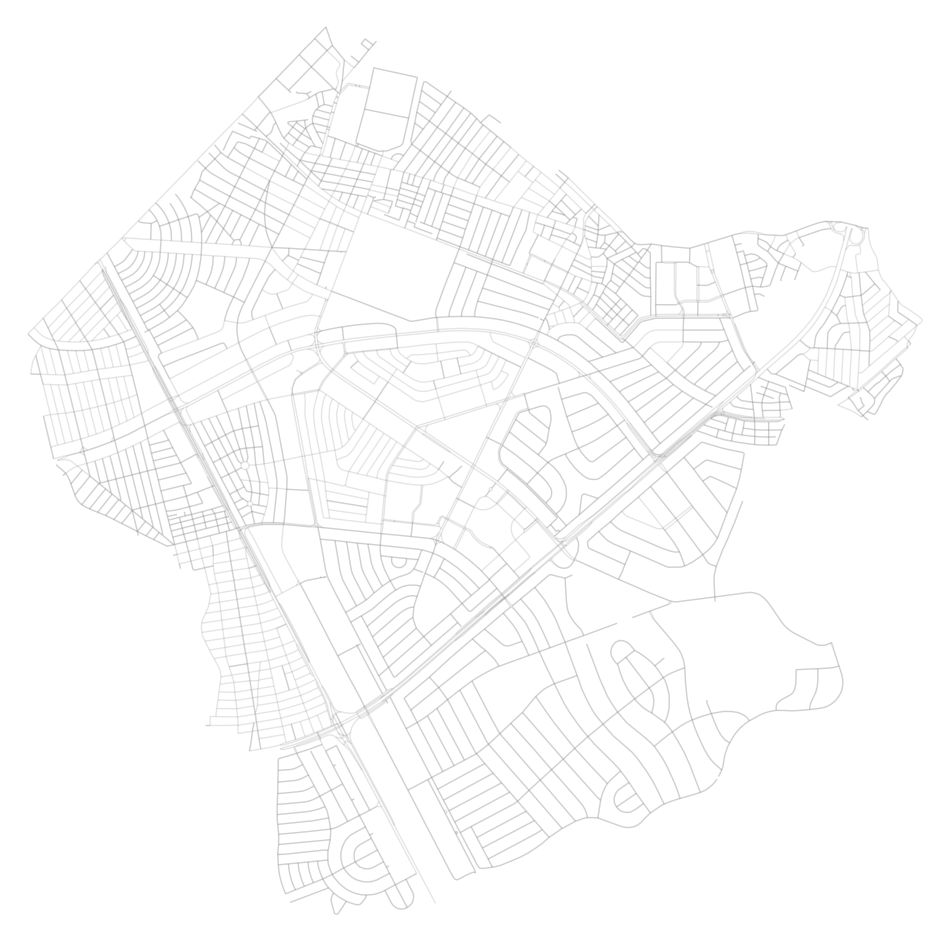

In [46]:
import osmnx as ox
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
# Initialize plot
fig, ax = plt.subplots(figsize=(12, 12))

# Plot the base graph
ox.plot_graph(graph_of_stops_Makati, ax=ax, node_size=0, show=False, close=False, edge_color='grey', edge_alpha=0.2)

# Define a color palette
colors = [
"Red", "Green", "Blue", "Yellow", "Orange", "Purple", "Cyan", "Magenta", "Maroon", "Lime", "Teal", "Navy", "Aqua", "Fuchsia", "Coral", "Indigo", "Violet"]


# Plot each path
for route in population[0].routes:
    for i, path in enumerate(route.route):
        # Extract the edges from the path
        edge_list = list(zip(path[:-1], path[1:]))
        
        # Get the coordinates of the nodes in the path
        route_nodes = [graph_of_stops_Makati.nodes[node] for node in path]
        
        chosen_color = random.choice(colors)
        # Plot the route
        for edge in edge_list:
            x = [graph_of_stops_Makati.nodes[edge[0]]['x'], graph_of_stops_Makati.nodes[edge[1]]['x']]
            y = [graph_of_stops_Makati.nodes[edge[0]]['y'], graph_of_stops_Makati.nodes[edge[1]]['y']]
            ax.plot(x, y, color=chosen_color, linewidth=2, alpha=0.7)
            
         # Plot the start and end points
        start_x, start_y = graph_of_stops_Makati.nodes[path[0]]['x'], graph_of_stops_Makati.nodes[path[0]]['y']
        end_x, end_y = graph_of_stops_Makati.nodes[path[-1]]['x'], graph_of_stops_Makati.nodes[path[-1]]['y']
        
        ax.scatter(start_x, start_y, color=chosen_color, edgecolor='black', s=50, alpha=0.7, zorder=3, label=f'Route {i+1} Start')
        ax.scatter(end_x, end_y, color=chosen_color, edgecolor='black', s=50, alpha=0.7, zorder=3, label=f'Route {i+1} End')

# Apply Seaborn styling
sns.despine()
plt.title('Makati Roads with Routes')
plt.show()

#### Visualization of Allowed Roads for Stops

In [ ]:
# filtered_road_map = plot_all_filtered_roads()
# filtered_road_map.save(f"{Makati_map_filepath}Allowed_Roads.html")

#### Visualization of Transpo Stops

In [84]:
stops_map = plot_stops_on_map(list_of_stops_Makati)
stops_map.save(f"{Makati_map_filepath}stops_map.html") # Save the map to an HTML file

In [85]:
population[0].fitness_score

14.54216570615856

In [88]:
import csv

with open('GA Result Route Networks HTML/Makati_routes.csv', mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['lat', 'long', 'route id'])
    
    for route in population[0].routes:
        for connection in route.route:
            if route.route.index(connection) == 0:
                lat = graph_of_stops_Makati.nodes[connection[0]]['y']
                long = graph_of_stops_Makati.nodes[connection[0]]['x']
                writer.writerow([lat, long, route.route_id])
            
            lat = graph_of_stops_Makati.nodes[connection[-1]]['y']
            long = graph_of_stops_Makati.nodes[connection[-1]]['x']
            writer.writerow([lat, long, route.route_id])

print("Data exported successfully.")

Data exported successfully.
